In [1]:
import sys
sys.path.append('/home/jasperdj/sai-git/sai/scripts/')
from matplotlib.colors import Normalize, CenteredNorm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#plt.style.use('seaborn-talk') 
plt.style.use('seaborn-v0_8-talk')
from load_SAIdata import Cases
from xarray_funcs import wmean
import cmocean
import cartopy.crs as ccrs
from dask.distributed import LocalCluster, Client, progress
import numpy as np
import xarray as xr
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# initiate dask cluster for parallel computing
cluster = LocalCluster(n_workers=16, threads_per_worker=1, memory_limit="14GiB", processes=True)
client = Client(cluster)
cluster, client

(LocalCluster(a6445585, 'tcp://127.0.0.1:34629', workers=16, threads=16, memory=224.00 GiB),
 <Client: 'tcp://127.0.0.1:34629' processes=16 threads=16, memory=224.00 GiB>)

In [3]:
def center_time(ds):
    """set time stamps to center of time_bnds"""
    time = ('time', ds.time_bnds.mean('nbnd').data, ds.time.attrs)
    ds = ds.assign_coords({'ctime':time}).swap_dims({'time':'ctime'})
    return ds.drop_vars('time').rename({'ctime':'time'})


def shift_time(ds, ndays):
    """shift time of dataset by ndays days"""
    dt = datetime.timedelta(days=ndays)
    t0, t1 = ds.time.data[[0,-1]]
    print(f"Shifting time period from {t0}--{t1} to {t0+dt}--{t1+dt}")
    ds = ds.assign(time_bnds=(ds.time_bnds.dims,(ds.time_bnds.compute()+dt).data,ds.time_bnds.attrs))
    return ds.assign(time=(ds.time.dims,(ds.time+dt).data,ds.time.attrs))


In [4]:
Cases.cases

{'lres.spinup': '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f09_g16/spinup_pd_maxcores_f09_g16/OUTPUT',
 'lres.sai20': '/projects/0/nwo2021025/archive/lres_b.e10.B2000_CAM5.f09_g16.feedforward.001',
 'lres.sai': '/projects/0/nwo2021025/archive/lres_b.e10.B2000_CAM5.f09_g16.feedforward_2050.001',
 'mres.cnt': '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f05_t12/rcp8.5_co2_f05_t12',
 'mres.sai': '/projects/0/nwo2021025/archive/mres_b.e10.B2000_CAM5.f05_t12.001',
 'hres.ref.1': '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f02_t12/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.001/OUTPUT',
 'hres.ref.2': '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f02_t12/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.002/OUTPUT',
 'hres.ref.3': '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f02_t12/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.003/OUTPUT',
 'hres.ref.4': '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f02_t12/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_200

In [4]:
%%time
ds = Cases('hres.sai.1').select('atm','h0').open_mfdataset()

Reading combined kerchunk reference file /home/jasperdj/kerchunk/hres_b.e10.B2000_CAM5.f02_t12.started_2092-12_2097-12.001.cam2.h0.2092-12_2097-12.json
CPU times: user 168 ms, sys: 90.8 ms, total: 259 ms
Wall time: 412 ms


In [5]:
Cases('hres.cnt.1').select('atm','h2')

hres.cnt.1 -- b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2092-12.001
model component: atm
file stream: h2
first file: /projects/0/prace_imau/prace_2013081679/cesm1_0_4/f02_t12/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2092-12.001/OUTPUT/atm/hist/3h/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2092-12.001.cam2.h2.2092-12-01-10800.nc
last file: /projects/0/prace_imau/prace_2013081679/cesm1_0_4/f02_t12/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2092-12.001/OUTPUT/atm/hist/3h/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2092-12.001.cam2.h2.2097-12-31-10800.nc
number of files: 372
steps in first file: 32
time step in first file: 3.0H
time in first file: ['2092-12-01 03:00:00', '2092-12-01 06:00:00', '2092-12-01 09:00:00'] ...

## CAM H0 -- full time series

In [6]:
kwargs = {
    'mr-cnt': dict(label='mr-control', lw=2),
    'mr-sai': dict(label='mr-SAI2050', lw=1.5),
    'hr-cnt.1': dict(label='hr-control', lw=0.5, c='r'),
    'hr-cnt.2': dict(label=None, lw=0.5, c='r'),
    'hr-cnt.3': dict(label=None, lw=0.5, c='r'),
    'hr-cnt.4': dict(label=None, lw=0.5, c='r'),
    'hr-cnt.5': dict(label=None, lw=0.5, c='r'),
    'hr-sai.1': dict(label='hr-control', lw=0.5, c='b'),
    'hr-sai.2': dict(label=None, lw=0.5, c='b'),
    'hr-sai.3': dict(label=None, lw=0.5, c='b'),
    'hr-sai.4': dict(label=None, lw=0.5, c='b'),
    'hr-sai.5': dict(label=None, lw=0.5, c='b'),
}

In [3]:
%%time
tags = list(Cases.cases)[1:] # all experiments except spinup
VAR = 'TREFHT'
VARgm = {}
for tag in tags:
    with Cases(tag).select('atm','h0').open_mfdataset().chunk({'time':1}) as ds:
        VARgm[tag] = wmean(ds[[VAR,'time_bnds']], ds.gw, ('lat','lon'), keep_attrs=True).compute()
    del ds

Reading combined kerchunk reference file /home/jasperdj/kerchunk/lres_b.e10.B2000_CAM5.f09_g16.feedforward.001.cam2.h0.2000-01_2076-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/lres_b.e10.B2000_CAM5.f09_g16.feedforward_2050.001.cam2.h0.2000-01_2098-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/rcp8.5_co2_f05_t12.cam2.h0.2000-01_2074-09.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/mres_b.e10.B2000_CAM5.f05_t12.001.cam2.h0.2045-01_2098-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12_2012-12.001.cam2.h0.2002-12_2012-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12_2007-12.002.cam2.h0.2002-12_2007-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12_2007-12.003.cam2.h0.2002-12_2007-12.json
Reading comb

In [4]:
# preprocessing
for tag in tags:
    VARgm[tag] = VARgm[tag].assign_coords({'time':VARgm[tag].time_bnds.mean('nbnd', keep_attrs=True)}) # set time to mid of interval
    gb = VARgm[tag].groupby('time.year')
    VARgm[tag] = gb.where(gb.count()==12).dropna('time', how='all') # drop years with less than 12 values
    print(f'{tag}: {VARgm[tag].time.size/12} years')

lres.sai20: 77.0 years
lres.sai: 99.0 years
mres.cnt: 74.0 years
mres.sai: 54.0 years
hres.ref.1: 10.0 years
hres.ref.2: 5.0 years
hres.ref.3: 5.0 years
hres.ref.4: 5.0 years
hres.ref.5: 5.0 years
hres.ref.6: 2.0 years
hres.cnt.1: 5.0 years
hres.cnt.2: 5.0 years
hres.cnt.3: 5.0 years
hres.cnt.4: 5.0 years
hres.cnt.5: 5.0 years
hres.cnt.6: 5.0 years
hres.sai.1: 5.0 years
hres.sai.2: 5.0 years
hres.sai.3: 5.0 years
hres.sai.4: 5.0 years
hres.sai.5: 5.0 years
hres.sai.6: 2.0 years


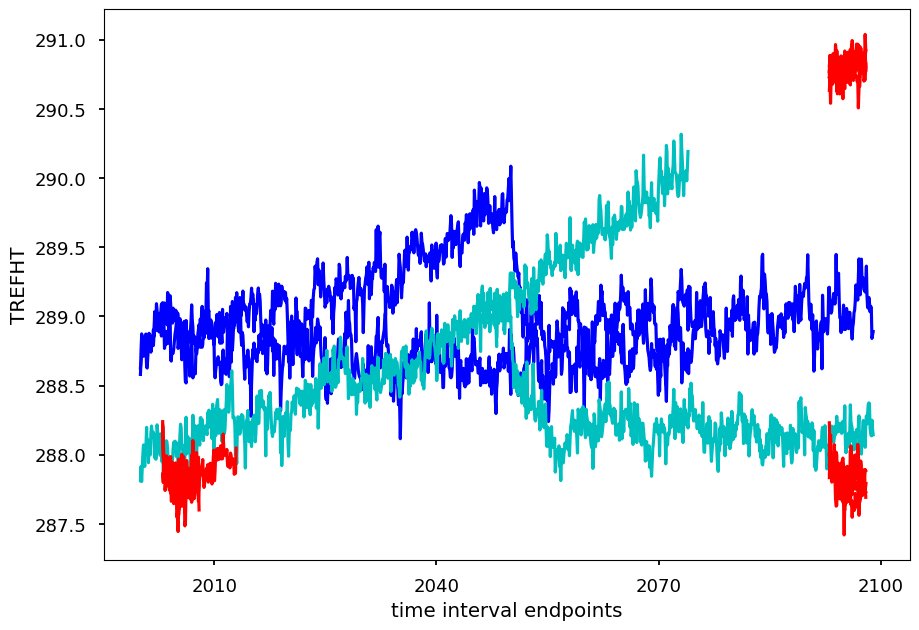

In [23]:
for tag in tags:
    Tref = VARgm[tag].TREFHT
    monmean = Tref.groupby('time.month').mean()
    monanom = monmean - monmean.mean()
    (Tref.groupby('time.month')-monanom).plot(c={'lres':'b','mres':'c','hres':'r'}[tag.split('.')[0]])


In [32]:
ds = VARgm[tags[5]]
gb = ds.groupby('time.year')
ds = gb.where(gb.count()==12).dropna('time',how='all') # only select years with 12 values
ds.groupby('time.year')

<xarray.Dataset> Size: 2kB
Dimensions:    (time: 60, nbnd: 2)
Coordinates:
  * time       (time) object 480B 2003-01-16 12:00:00 ... 2007-12-16 12:00:00
    year       (time) int64 480B 2003 2003 2003 2003 ... 2007 2007 2007 2007
Dimensions without coordinates: nbnd
Data variables:
    TREFHT     (time) float64 480B 286.3 286.4 287.0 287.8 ... 287.8 286.8 285.9
    time_bnds  (time, nbnd) object 960B 2003-01-01 00:00:00 ... 2008-01-01 00...

/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing with an out-of-order index is generating 54 times more chunks
  return self.array[key]


CPU times: user 18.6 s, sys: 3.44 s, total: 22.1 s
Wall time: 4min 17s


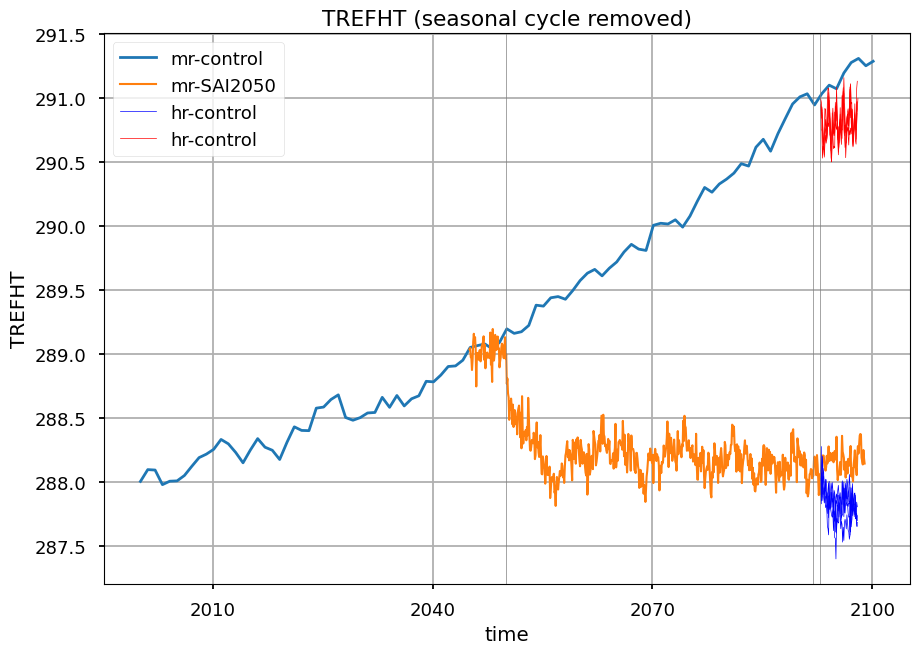

In [6]:
%%time
VAR = 'TREFHT'
tslice = slice(None,None)

VARSgm = {k:wmean(cam[k][VAR].sel(time=tslice), cam[k].gw, ('lat','lon')) for k in cam}
monmean = VARSgm['mr-sai'].groupby('time.month').mean()
anom = (monmean - monmean.mean('month')).compute()

for k in VARSgm:
    if k == 'mr-cnt':
        VARSgm[k].plot(**kwargs[k]) # yearly data
    else:
        (VARSgm[k].groupby('time.month')-anom).plot(**kwargs[k])
        
ax = plt.gca()
ax.axvline(50*365, c='gray', lw=.5)
ax.axvline((92-1/12)*365, c='gray', lw=.5)
ax.axvline((93-1/12)*365, c='gray', lw=.5)

ax.set_title(f'{VAR} (seasonal cycle removed)')
ax.grid()
ax.legend()

/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing with an out-of-order index is generating 54 times more chunks
  return self.array[key]


CPU times: user 13.8 s, sys: 3.57 s, total: 17.4 s
Wall time: 4min 52s


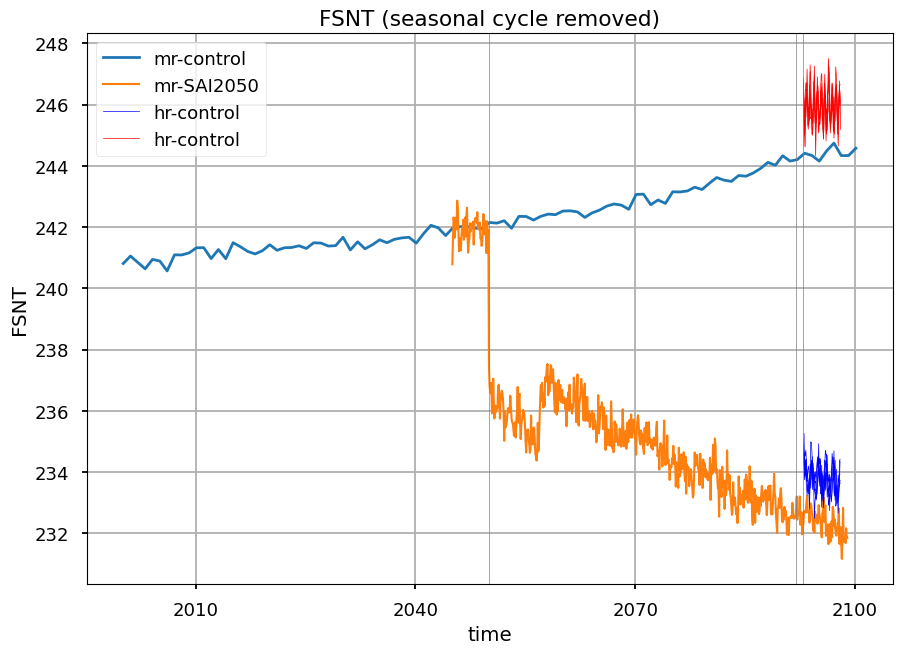

In [7]:
%%time
VAR = 'FSNT'
tslice = slice(None,None)

VARSgm = {k:wmean(cam[k][VAR].sel(time=tslice), cam[k].gw, ('lat','lon')) for k in cam}
monmean = VARSgm['mr-sai'].groupby('time.month').mean()
anom = (monmean - monmean.mean('month')).compute()

kwargs = {
    'mr-cnt': dict(label='mr-control', lw=2),
    'mr-sai': dict(label='mr-SAI2050', lw=1.5),
    'hr-cnt.1': dict(label='hr-control', lw=0.5, c='r'),
    'hr-cnt.2': dict(label=None, lw=0.5, c='r'),
    'hr-cnt.3': dict(label=None, lw=0.5, c='r'),
    'hr-cnt.4': dict(label=None, lw=0.5, c='r'),
    'hr-cnt.5': dict(label=None, lw=0.5, c='r'),
    'hr-sai.1': dict(label='hr-control', lw=0.5, c='b'),
    'hr-sai.2': dict(label=None, lw=0.5, c='b'),
    'hr-sai.3': dict(label=None, lw=0.5, c='b'),
    'hr-sai.4': dict(label=None, lw=0.5, c='b'),
    'hr-sai.5': dict(label=None, lw=0.5, c='b'),
}

for k in VARSgm:
    if k == 'mr-cnt':
        VARSgm[k].plot(**kwargs[k]) # yearly data
    else:
        (VARSgm[k].groupby('time.month')-anom).plot(**kwargs[k])
        
ax = plt.gca()
ax.axvline(50*365, c='gray', lw=.5)
ax.axvline((92-1/12)*365, c='gray', lw=.5)
ax.axvline((93-1/12)*365, c='gray', lw=.5)

ax.set_title(f'{VAR} (seasonal cycle removed)')
ax.grid()
ax.legend()

/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing with an out-of-order index is generating 54 times more chunks
  return self.array[key]


CPU times: user 12 s, sys: 806 ms, total: 12.8 s
Wall time: 19.5 s


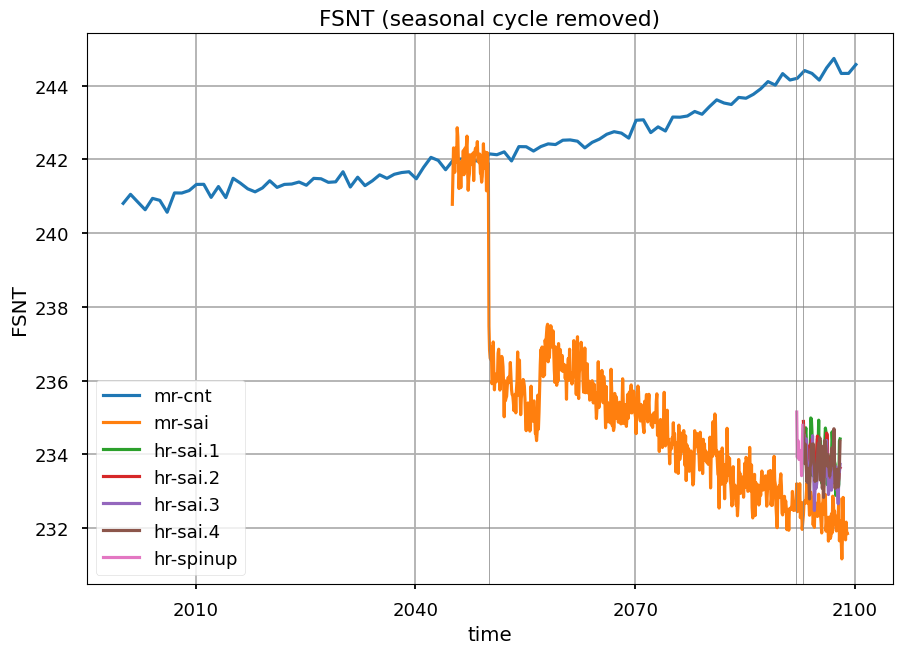

In [8]:
%%time
VAR = 'FSNT'
tslice = slice(None,None)

VARSgm = {k:wmean(cam[k][VAR].sel(time=tslice), cam[k].gw, ('lat','lon')) for k in cam}
monmean = VARSgm['mr-sai'].groupby('time.month').mean()
anom = (monmean - monmean.mean('month')).compute()

for k in VARSgm:
    if k == 'mr-cnt':
        VARSgm[k].plot(label=k) # yearly data
    else:
        (VARSgm[k].groupby('time.month')-anom).plot(label=k)
        
ax = plt.gca()
ax.axvline(50*365, c='gray', lw=.5)
ax.axvline((92-1/12)*365, c='gray', lw=.5)
ax.axvline((93-1/12)*365, c='gray', lw=.5)

ax.set_title(f'{VAR} (seasonal cycle removed)')
ax.grid()
ax.legend()

/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing with an out-of-order index is generating 54 times more chunks
  return self.array[key]


CPU times: user 16.4 s, sys: 888 ms, total: 17.3 s
Wall time: 24.6 s


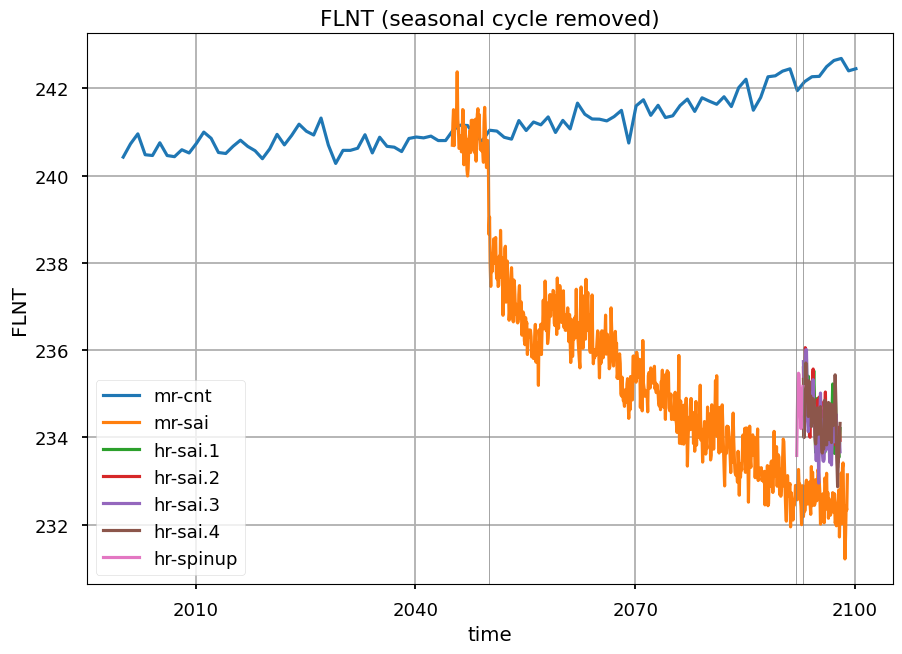

In [9]:
%%time
VAR = 'FLNT'
tslice = slice(None,None)

VARSgm = {k:wmean(cam[k][VAR].sel(time=tslice), cam[k].gw, ('lat','lon')) for k in cam}
monmean = VARSgm['mr-sai'].groupby('time.month').mean()
anom = (monmean - monmean.mean('month')).compute()

for k in VARSgm:
    if k == 'mr-cnt':
        VARSgm[k].plot(label=k) # yearly data
    else:
        (VARSgm[k].groupby('time.month')-anom).plot(label=k)
        
ax = plt.gca()
ax.axvline(50*365, c='gray', lw=.5)
ax.axvline((92-1/12)*365, c='gray', lw=.5)
ax.axvline((93-1/12)*365, c='gray', lw=.5)

ax.set_title(f'{VAR} (seasonal cycle removed)')
ax.grid()
ax.legend()

/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing with an out-of-order index is generating 54 times more chunks
  return self.array[key]


CPU times: user 12.1 s, sys: 804 ms, total: 13 s
Wall time: 19.6 s


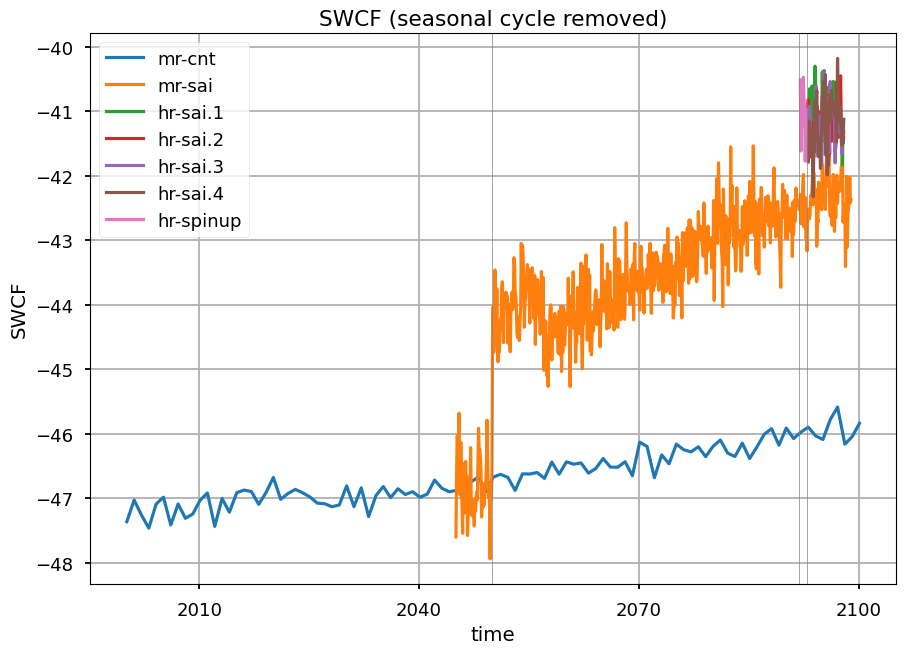

In [10]:
%%time
VAR = 'SWCF'
tslice = slice(None,None)

VARSgm = {k:wmean(cam[k][VAR].sel(time=tslice), cam[k].gw, ('lat','lon')) for k in cam}
monmean = VARSgm['mr-sai'].groupby('time.month').mean()
anom = (monmean - monmean.mean('month')).compute()

for k in VARSgm:
    if k == 'mr-cnt':
        VARSgm[k].plot(label=k) # yearly data
    else:
        (VARSgm[k].groupby('time.month')-anom).plot(label=k)
        
ax = plt.gca()
ax.axvline(50*365, c='gray', lw=.5)
ax.axvline((92-1/12)*365, c='gray', lw=.5)
ax.axvline((93-1/12)*365, c='gray', lw=.5)

ax.set_title(f'{VAR} (seasonal cycle removed)')
ax.grid()
ax.legend()

/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing with an out-of-order index is generating 54 times more chunks
  return self.array[key]


CPU times: user 16.4 s, sys: 858 ms, total: 17.2 s
Wall time: 24 s


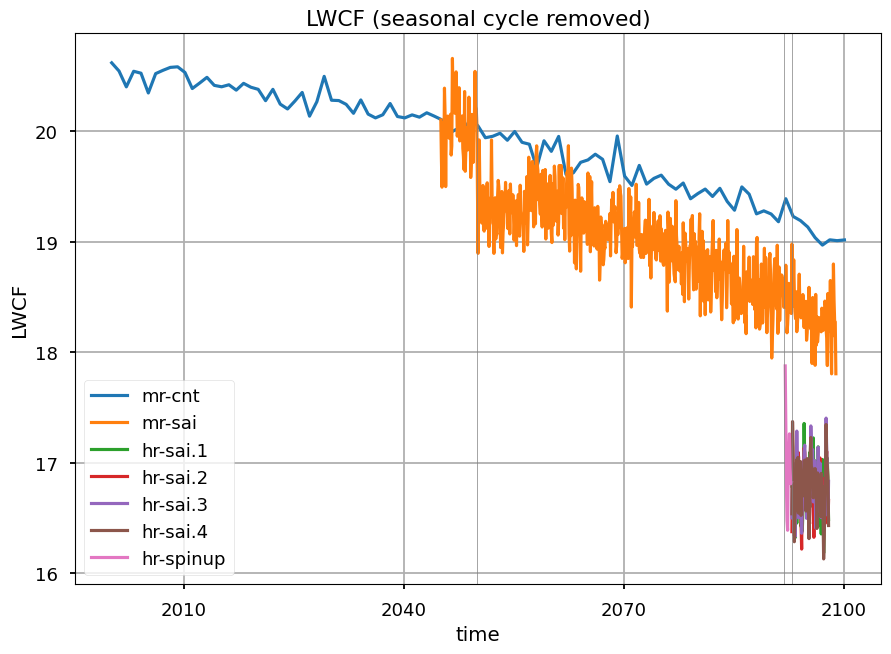

In [11]:
%%time
VAR = 'LWCF'
tslice = slice(None,None)

VARSgm = {k:wmean(cam[k][VAR].sel(time=tslice), cam[k].gw, ('lat','lon')) for k in cam}
monmean = VARSgm['mr-sai'].groupby('time.month').mean()
anom = (monmean - monmean.mean('month')).compute()

for k in VARSgm:
    if k == 'mr-cnt':
        VARSgm[k].plot(label=k) # yearly data
    else:
        (VARSgm[k].groupby('time.month')-anom).plot(label=k)
        
ax = plt.gca()
ax.axvline(50*365, c='gray', lw=.5)
ax.axvline((92-1/12)*365, c='gray', lw=.5)
ax.axvline((93-1/12)*365, c='gray', lw=.5)

ax.set_title(f'{VAR} (seasonal cycle removed)')
ax.grid()
ax.legend()

## CAM h0 -- time series from 2080

/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing with an out-of-order index is generating 19 times more chunks
  return self.array[key]
2025-01-15 12:03:06,523 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


CPU times: user 8.62 s, sys: 667 ms, total: 9.29 s
Wall time: 16.2 s


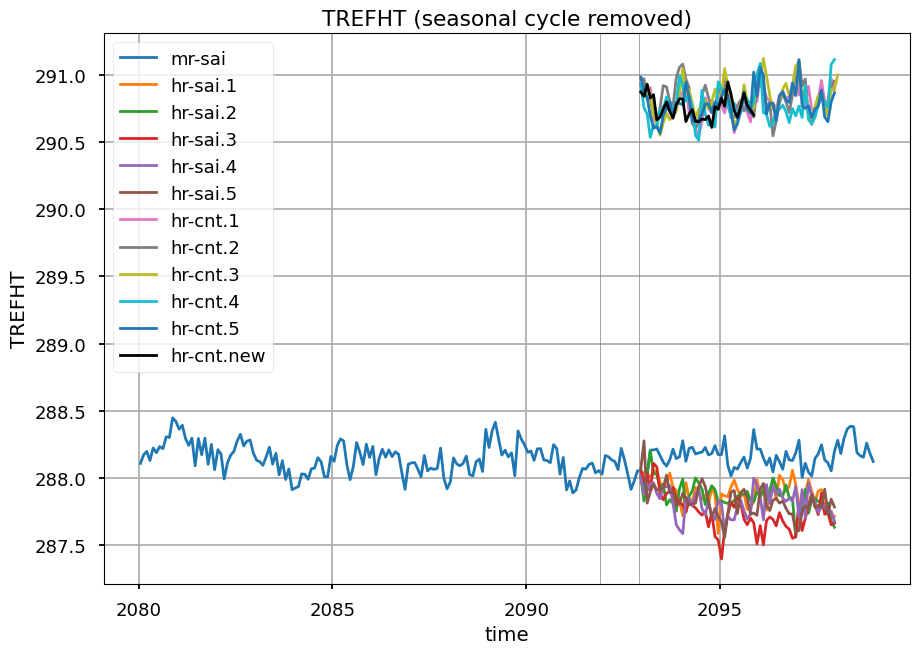

In [12]:
%%time
VAR = 'TREFHT'
tslice = slice('2080',None)

VARSgm = {k:wmean(cam[k][VAR].sel(time=tslice), cam[k].gw, ('lat','lon')) for k in cam}
monmean = VARSgm['mr-sai'].groupby('time.month').mean()
anom = (monmean - monmean.mean('month')).compute()

for k in VARSgm:
    if k == 'mr-cnt':
        continue
    if k == 'hr-cnt.new':
        (VARSgm[k].groupby('time.month')-anom).plot(lw=2, zorder=5, label=k, c='k')
    else:
        (VARSgm[k].groupby('time.month')-anom).plot(lw=2, label=k)

ax = plt.gca()
ax.axvline((92-1/12)*365, c='gray', lw=.5)
ax.axvline((93-1/12)*365, c='gray', lw=.5)

ax.set_title(f'{VAR} (seasonal cycle removed)')
ax.grid()
ax.legend()

/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing with an out-of-order index is generating 19 times more chunks
  return self.array[key]


CPU times: user 5.65 s, sys: 352 ms, total: 6 s
Wall time: 9.06 s


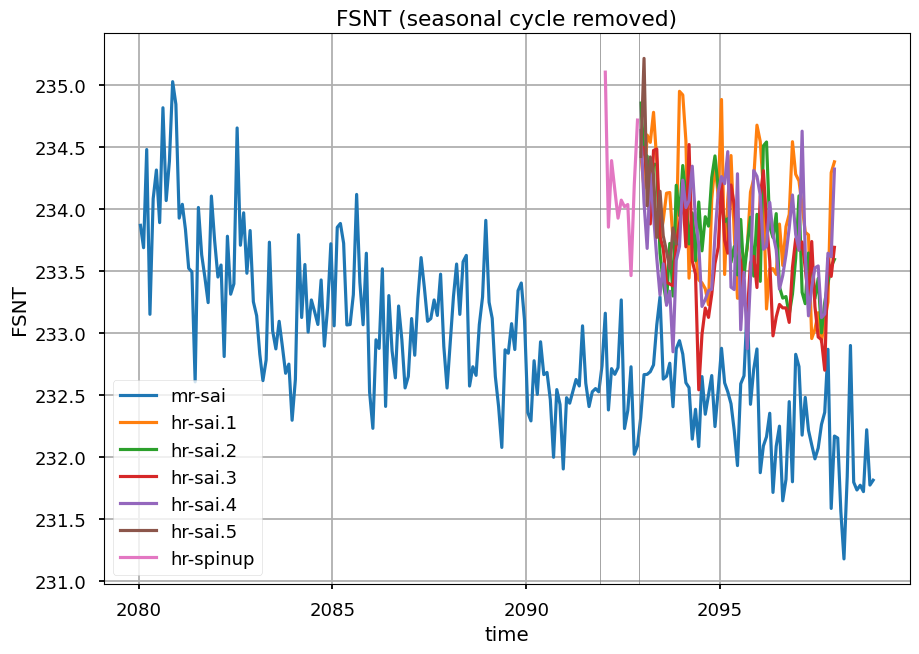

In [9]:
%%time
VAR = 'FSNT'
tslice = slice('2080',None)

VARSgm = {k:wmean(cam[k][VAR].sel(time=tslice), cam[k].gw, ('lat','lon')) for k in cam}
monmean = VARSgm['mr-sai'].groupby('time.month').mean()
anom = (monmean - monmean.mean('month')).compute()

for k in VARSgm:
    if k == 'mr-cnt':
        continue
    (VARSgm[k].groupby('time.month')-anom).plot(label=k)

ax = plt.gca()
ax.axvline((92-1/12)*365, c='gray', lw=.5)
ax.axvline((93-1/12)*365, c='gray', lw=.5)

ax.set_title(f'{VAR} (seasonal cycle removed)')
ax.grid()
ax.legend()

/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing with an out-of-order index is generating 19 times more chunks
  return self.array[key]


CPU times: user 5.76 s, sys: 400 ms, total: 6.16 s
Wall time: 9.69 s


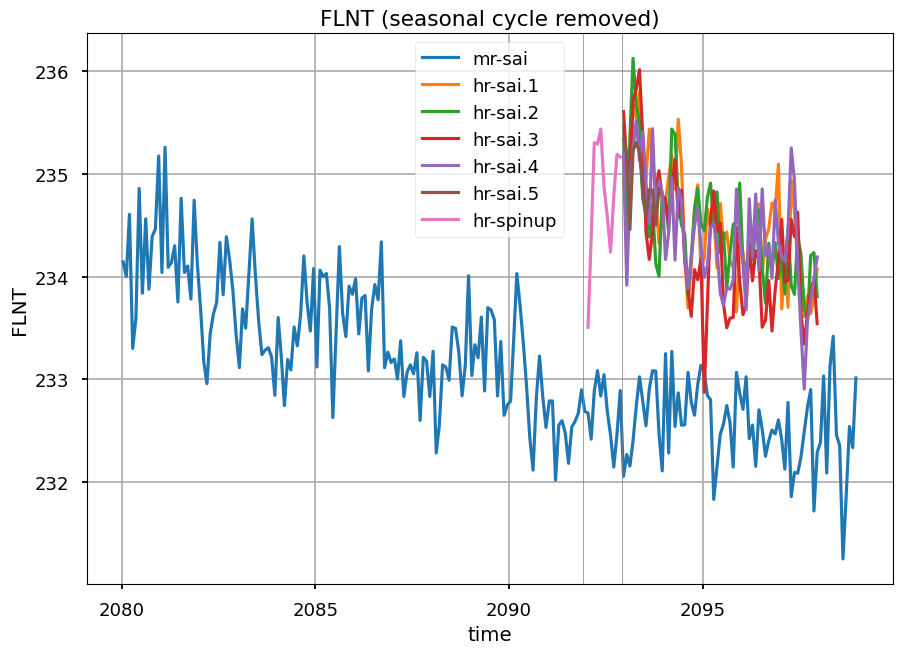

In [10]:
%%time
VAR = 'FLNT'
tslice = slice('2080',None)

VARSgm = {k:wmean(cam[k][VAR].sel(time=tslice), cam[k].gw, ('lat','lon')) for k in cam}
monmean = VARSgm['mr-sai'].groupby('time.month').mean()
anom = (monmean - monmean.mean('month')).compute()

for k in VARSgm:
    if k == 'mr-cnt':
        continue
    (VARSgm[k].groupby('time.month')-anom).plot(label=k)

ax = plt.gca()
ax.axvline((92-1/12)*365, c='gray', lw=.5)
ax.axvline((93-1/12)*365, c='gray', lw=.5)

ax.set_title(f'{VAR} (seasonal cycle removed)')
ax.grid()
ax.legend()

/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing with an out-of-order index is generating 19 times more chunks
  return self.array[key]


CPU times: user 5.63 s, sys: 388 ms, total: 6.02 s
Wall time: 8.9 s


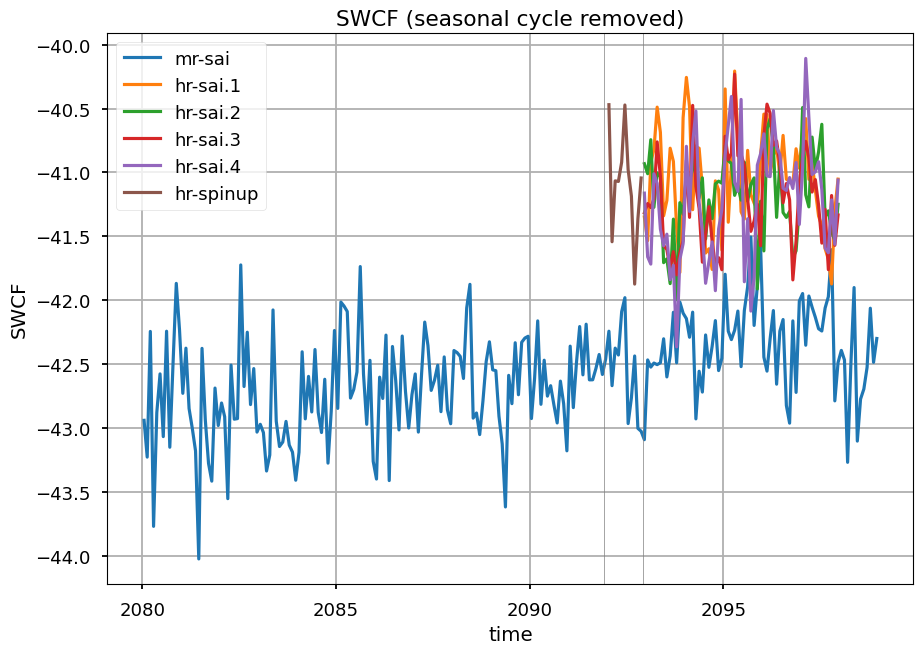

In [15]:
%%time
VAR = 'SWCF'
tslice = slice('2080',None)

VARSgm = {k:wmean(cam[k][VAR].sel(time=tslice), cam[k].gw, ('lat','lon')) for k in cam}
monmean = VARSgm['mr-sai'].groupby('time.month').mean()
anom = (monmean - monmean.mean('month')).compute()

for k in VARSgm:
    if k == 'mr-cnt':
        continue
    (VARSgm[k].groupby('time.month')-anom).plot(label=k)

ax = plt.gca()
ax.axvline((92-1/12)*365, c='gray', lw=.5)
ax.axvline((93-1/12)*365, c='gray', lw=.5)

ax.set_title(f'{VAR} (seasonal cycle removed)')
ax.grid()
ax.legend()

/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing with an out-of-order index is generating 19 times more chunks
  return self.array[key]


CPU times: user 9.93 s, sys: 447 ms, total: 10.4 s
Wall time: 14.2 s


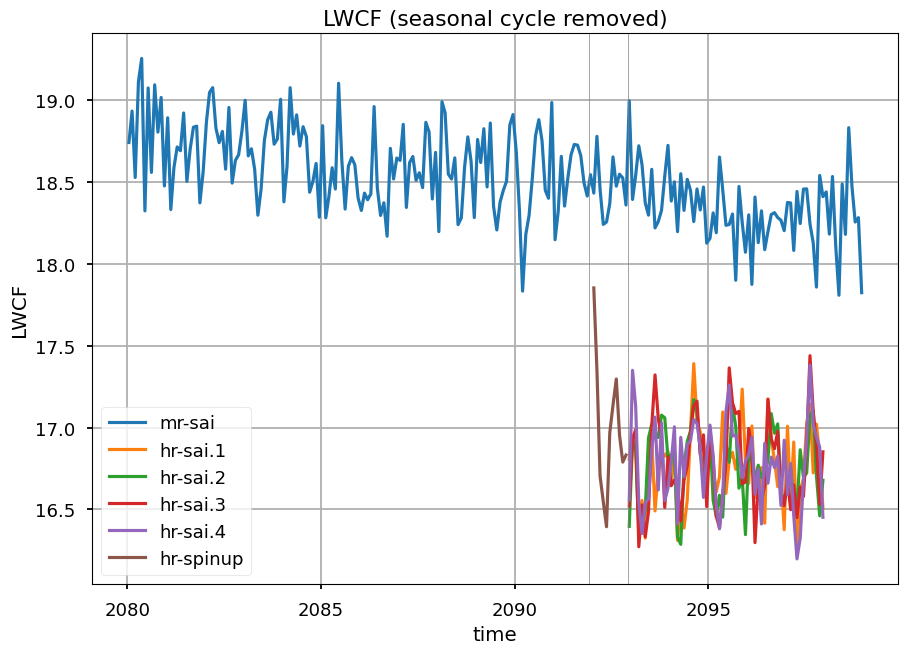

In [16]:
%%time
VAR = 'LWCF'
tslice = slice('2080',None)

VARSgm = {k:wmean(cam[k][VAR].sel(time=tslice), cam[k].gw, ('lat','lon')) for k in cam}
monmean = VARSgm['mr-sai'].groupby('time.month').mean()
anom = (monmean - monmean.mean('month')).compute()

for k in VARSgm:
    if k == 'mr-cnt':
        continue
    (VARSgm[k].groupby('time.month')-anom).plot(label=k)

ax = plt.gca()
ax.axvline((92-1/12)*365, c='gray', lw=.5)
ax.axvline((93-1/12)*365, c='gray', lw=.5)

ax.set_title(f'{VAR} (seasonal cycle removed)')
ax.grid()
ax.legend()

/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing with an out-of-order index is generating 19 times more chunks
  return self.array[key]


CPU times: user 5.73 s, sys: 397 ms, total: 6.13 s
Wall time: 10.4 s


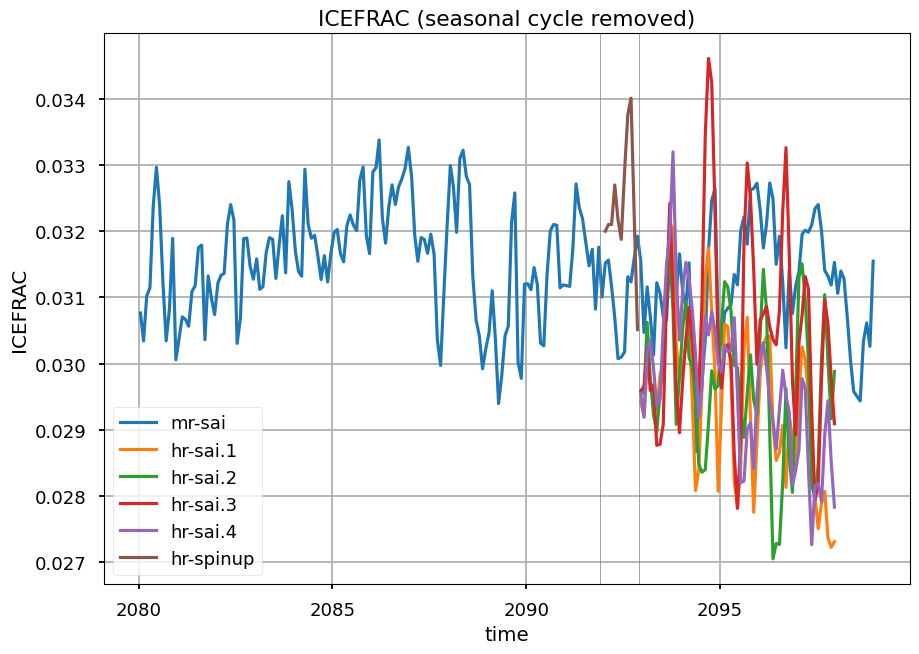

In [19]:
%%time
VAR = 'ICEFRAC'
tslice = slice('2080',None)

VARSgm = {k:wmean(cam[k][VAR].sel(time=tslice), cam[k].gw, ('lat','lon')) for k in cam}
monmean = VARSgm['mr-sai'].groupby('time.month').mean()
anom = (monmean - monmean.mean('month')).compute()

for k in VARSgm:
    if k == 'mr-cnt':
        continue
    (VARSgm[k].groupby('time.month')-anom).plot(label=k)

ax = plt.gca()
ax.axvline((92-1/12)*365, c='gray', lw=.5)
ax.axvline((93-1/12)*365, c='gray', lw=.5)

ax.set_title(f'{VAR} (seasonal cycle removed)')
ax.grid()
ax.legend()

## CAM h0 -- maps

In [17]:
for k in cam:
    print(k, cam[k].time.min().item().strftime("%Y-%m-%d"), cam[k].time.max().item().strftime("%Y-%m-%d"))

mr-cnt 2000-02-15 2100-02-15
mr-sai 2045-01-16 2098-12-16
hr-sai.1 2092-12-16 2097-12-16
hr-sai.2 2092-12-16 2097-12-16
hr-sai.3 2092-12-16 2097-12-16
hr-sai.4 2092-12-16 2097-12-16
hr-spinup 2092-01-16 2092-11-16


Text(0.5, 0.98, '2092-12 - 2097-12')

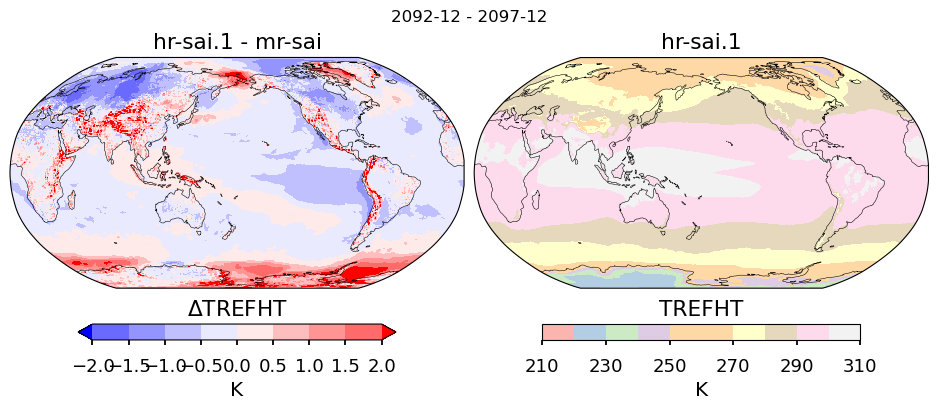

In [63]:
VAR = 'TREFHT'
tslice = slice('2092-12','2097-12')
dlevels = np.arange(-2,2.1,0.5) # levels of hr - mr difference plot
levels = range(210,311,10) # levels hr plot
mrname = 'mr-sai'
hrname = 'hr-sai.1'

Zmr = cam[mrname][VAR].sel(time=tslice).mean('time', keep_attrs=True)
Zhr = cam[hrname][VAR].sel(time=tslice).mean('time', keep_attrs=True)
Zdiff = Zhr.interp(lat=Zmr.lat, lon=Zmr.lon) - Zmr

#Y = (cam['hrt'][VAR].sel(time=tslice).interp(lat=cam['geo'].lat, lon=cam['geo'].lon) - cam['geo'][VAR].sel(time=tslice)).mean('time', keep_attrs=True)

fig,ax = plt.subplots(1,2, layout="compressed", figsize=(10,4), subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
pd = ax[0].contourf(Zdiff.lon, Zdiff.lat, Zdiff, levels=dlevels, cmap='bwr', transform=ccrs.PlateCarree(), extend='both',
                    norm=CenteredNorm(vcenter=0, halfrange=max(dlevels)*1.5))
ax[0].coastlines()
cb = fig.colorbar(pd, ax=ax[0], orientation='horizontal', shrink=.7, label=Zhr.units)
cb.ax.set_title(r"$\Delta$"+VAR)
ax[0].set_title(f'{hrname} - {mrname}')

ps = ax[1].contourf(Zhr.lon, Zhr.lat, Zhr, 
                    levels=levels, transform=ccrs.PlateCarree(), cmap='Pastel1')
ax[1].set_title(hrname)
ax[1].coastlines()
cb2 = fig.colorbar(ps, ax=ax[1], orientation='horizontal', shrink=.7, label=Zhr.units)
cb2.ax.set_title(VAR)
fig.suptitle(f"{tslice.start} - {tslice.stop}")

Text(0.5, 0.98, '2092-12 - 2097-12')

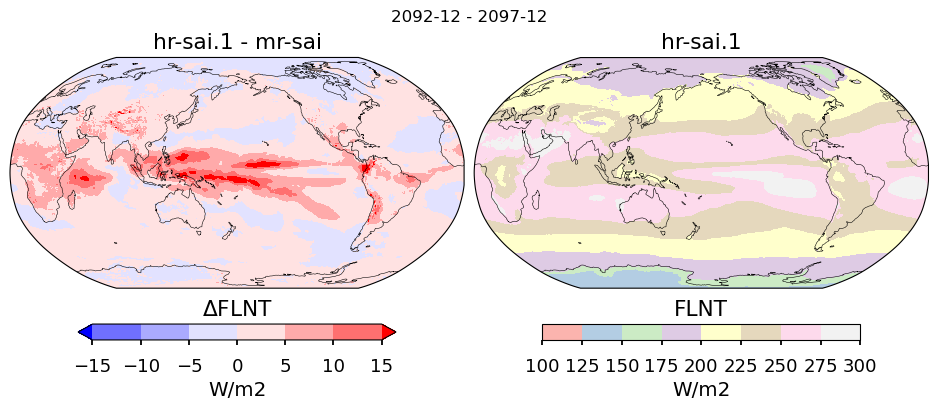

In [61]:
VAR = 'FLNT'
tslice = slice('2092-12','2097-12')
dlevels = np.arange(-15,16,5) # levels of hr - mr difference plot
levels = range(100,301,25) # levels hr plot
mrname = 'mr-sai'
hrname = 'hr-sai.1'

Zmr = cam[mrname][VAR].sel(time=tslice).mean('time', keep_attrs=True)
Zhr = cam[hrname][VAR].sel(time=tslice).mean('time', keep_attrs=True)
Zdiff = Zhr.interp(lat=Zmr.lat, lon=Zmr.lon) - Zmr

#Y = (cam['hrt'][VAR].sel(time=tslice).interp(lat=cam['geo'].lat, lon=cam['geo'].lon) - cam['geo'][VAR].sel(time=tslice)).mean('time', keep_attrs=True)

fig,ax = plt.subplots(1,2, layout="compressed", figsize=(10,4), subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
pd = ax[0].contourf(Zdiff.lon, Zdiff.lat, Zdiff, levels=dlevels, cmap='bwr', transform=ccrs.PlateCarree(), extend='both',
                    norm=CenteredNorm(vcenter=0, halfrange=max(dlevels)*1.5))
ax[0].coastlines()
cb = fig.colorbar(pd, ax=ax[0], orientation='horizontal', shrink=.7, label=Zhr.units)
cb.ax.set_title(r"$\Delta$"+VAR)
ax[0].set_title(f'{hrname} - {mrname}')

ps = ax[1].contourf(Zhr.lon, Zhr.lat, Zhr, 
                    levels=levels, transform=ccrs.PlateCarree(), cmap='Pastel1')
ax[1].set_title(hrname)
ax[1].coastlines()
cb2 = fig.colorbar(ps, ax=ax[1], orientation='horizontal', shrink=.7, label=Zhr.units)
cb2.ax.set_title(VAR)
fig.suptitle(f"{tslice.start} - {tslice.stop}")

Text(0.5, 0.98, '2092-12 - 2097-12')

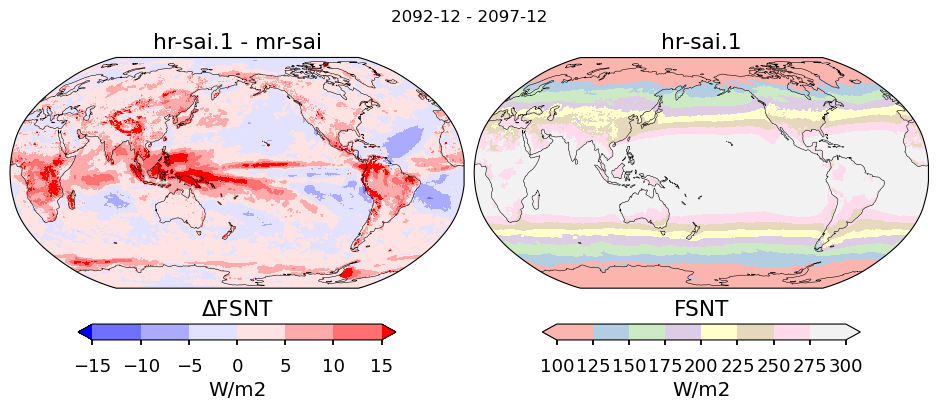

In [67]:
VAR = 'FSNT'
tslice = slice('2092-12','2097-12')
dlevels = np.arange(-15,16,5) # levels of hr - mr difference plot
levels = range(100,301,25) # levels hr plot
mrname = 'mr-sai'
hrname = 'hr-sai.1'

Zmr = cam[mrname][VAR].sel(time=tslice).mean('time', keep_attrs=True)
Zhr = cam[hrname][VAR].sel(time=tslice).mean('time', keep_attrs=True)
Zdiff = Zhr.interp(lat=Zmr.lat, lon=Zmr.lon) - Zmr

#Y = (cam['hrt'][VAR].sel(time=tslice).interp(lat=cam['geo'].lat, lon=cam['geo'].lon) - cam['geo'][VAR].sel(time=tslice)).mean('time', keep_attrs=True)

fig,ax = plt.subplots(1,2, layout="compressed", figsize=(10,4), subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
pd = ax[0].contourf(Zdiff.lon, Zdiff.lat, Zdiff, levels=dlevels, cmap='bwr', transform=ccrs.PlateCarree(), extend='both',
                    norm=CenteredNorm(vcenter=0, halfrange=max(dlevels)*1.5))
ax[0].coastlines()
cb = fig.colorbar(pd, ax=ax[0], orientation='horizontal', shrink=.7, label=Zhr.units)
cb.ax.set_title(r"$\Delta$"+VAR)
ax[0].set_title(f'{hrname} - {mrname}')

ps = ax[1].contourf(Zhr.lon, Zhr.lat, Zhr, 
                    levels=levels, transform=ccrs.PlateCarree(), cmap='Pastel1', extend='both')
ax[1].set_title(hrname)
ax[1].coastlines()
cb2 = fig.colorbar(ps, ax=ax[1], orientation='horizontal', shrink=.7, label=Zhr.units)
cb2.ax.set_title(VAR)
fig.suptitle(f"{tslice.start} - {tslice.stop}")

## OLD

Text(0.5, 0.98, '2092-07 - 2092-11')

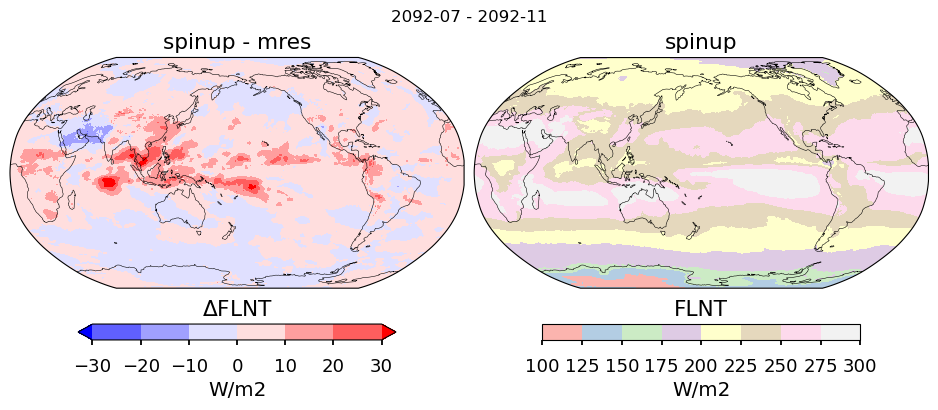

In [38]:
VAR = 'FLNT'
tslice = slice('2092-07','2092-11')
dlevels = range(-30,31,10)
levels = range(100,301,25)
Y = (cam['hrt'][VAR].sel(time=tslice).interp(lat=cam['geo'].lat, lon=cam['geo'].lon) - cam['geo'][VAR].sel(time=tslice)).mean('time', keep_attrs=True)

fig,ax = plt.subplots(1,2, layout="compressed", figsize=(10,4), subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
pd = ax[0].contourf(Y.lon, Y.lat, Y, levels=dlevels, cmap='bwr', transform=ccrs.PlateCarree(), extend='both',
                    norm=CenteredNorm(vcenter=0, halfrange=40))
ax[0].coastlines()
cb = fig.colorbar(pd, ax=ax[0], orientation='horizontal', shrink=.7, label=cam['hrt'][VAR].units)
cb.ax.set_title(r"$\Delta$"+VAR)
ax[0].set_title('spinup - mres')

ps = ax[1].contourf(cam['hrt'].lon, cam['hrt'].lat, cam['hrt'][VAR].sel(time=tslice).mean('time',keep_attrs=True), 
                    levels=levels, transform=ccrs.PlateCarree(), cmap='Pastel1')
ax[1].set_title('spinup')
ax[1].coastlines()
cb2 = fig.colorbar(ps, ax=ax[1], orientation='horizontal', shrink=.7, label=cam['hrt'][VAR].units)
cb2.ax.set_title(VAR)
fig.suptitle(f"{tslice.start} - {tslice.stop}")

Text(0.5, 0.98, '2092-01 - 2092-06')

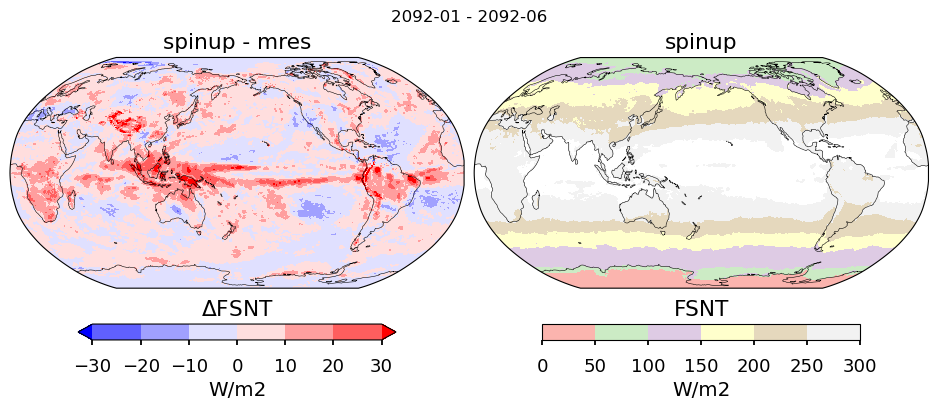

In [39]:
VAR = 'FSNT'
tslice = slice('2092-01','2092-06')
dlevels = range(-30,31,10)
levels = range(0,301,50)
Y = (cam['hrt'][VAR].sel(time=tslice).interp(lat=cam['geo'].lat, lon=cam['geo'].lon) - cam['geo'][VAR].sel(time=tslice)).mean('time', keep_attrs=True)

fig,ax = plt.subplots(1,2, layout="compressed", figsize=(10,4), subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
pd = ax[0].contourf(Y.lon, Y.lat, Y, levels=dlevels, cmap='bwr', transform=ccrs.PlateCarree(), extend='both',
                    norm=CenteredNorm(vcenter=0, halfrange=40))
ax[0].coastlines()
cb = fig.colorbar(pd, ax=ax[0], orientation='horizontal', shrink=.7, label=cam['hrt'][VAR].units)
cb.ax.set_title(r"$\Delta$"+VAR)
ax[0].set_title('spinup - mres')

ps = ax[1].contourf(cam['hrt'].lon, cam['hrt'].lat, cam['hrt'][VAR].sel(time=tslice).mean('time',keep_attrs=True), 
                    levels=levels, transform=ccrs.PlateCarree(), cmap='Pastel1')
ax[1].set_title('spinup')
ax[1].coastlines()
cb2 = fig.colorbar(ps, ax=ax[1], orientation='horizontal', shrink=.7, label=cam['hrt'][VAR].units)
cb2.ax.set_title(VAR)
fig.suptitle(f"{tslice.start} - {tslice.stop}")

Text(0.5, 0.98, '2092-07 - 2092-11')

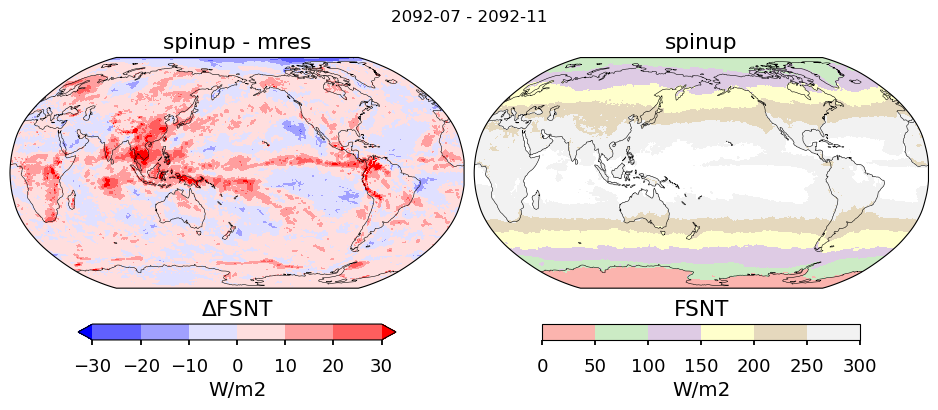

In [41]:
VAR = 'FSNT'
tslice = slice('2092-07','2092-11')
dlevels = range(-30,31,10)
levels = range(0,301,50)
Y = (cam['hrt'][VAR].sel(time=tslice).interp(lat=cam['geo'].lat, lon=cam['geo'].lon) - cam['geo'][VAR].sel(time=tslice)).mean('time', keep_attrs=True)

fig,ax = plt.subplots(1,2, layout="compressed", figsize=(10,4), subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
pd = ax[0].contourf(Y.lon, Y.lat, Y, levels=dlevels, cmap='bwr', transform=ccrs.PlateCarree(), extend='both',
                    norm=CenteredNorm(vcenter=0, halfrange=40))
ax[0].coastlines()
cb = fig.colorbar(pd, ax=ax[0], orientation='horizontal', shrink=.7, label=cam['hrt'][VAR].units)
cb.ax.set_title(r"$\Delta$"+VAR)
ax[0].set_title('spinup - mres')

ps = ax[1].contourf(cam['hrt'].lon, cam['hrt'].lat, cam['hrt'][VAR].sel(time=tslice).mean('time',keep_attrs=True), 
                    levels=levels, transform=ccrs.PlateCarree(), cmap='Pastel1')
ax[1].set_title('spinup')
ax[1].coastlines()
cb2 = fig.colorbar(ps, ax=ax[1], orientation='horizontal', shrink=.7, label=cam['hrt'][VAR].units)
cb2.ax.set_title(VAR)
fig.suptitle(f"{tslice.start} - {tslice.stop}")

Text(0.5, 0.98, '2092-01 - 2092-06')

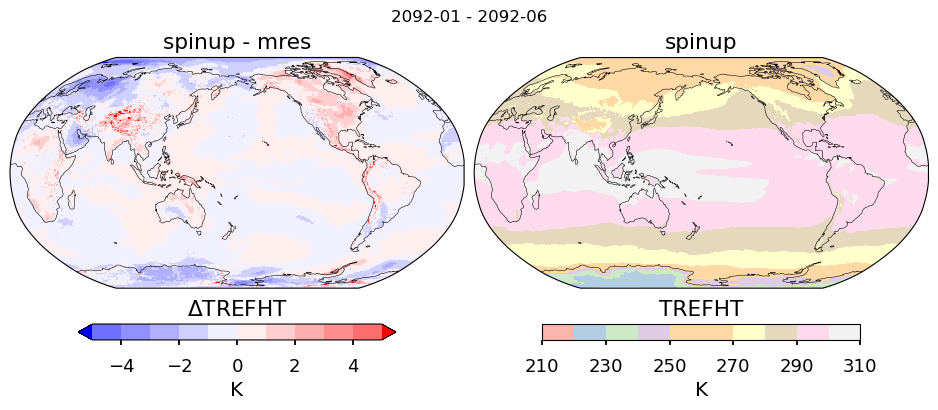

In [35]:
VAR = 'TREFHT'
tslice = slice('2092-01','2092-06')
dlevels = range(-5,6,1)
levels = range(210,311,10)
Y = (cam['hrt'][VAR].sel(time=tslice).interp(lat=cam['geo'].lat, lon=cam['geo'].lon) - cam['geo'][VAR].sel(time=tslice)).mean('time', keep_attrs=True)

fig,ax = plt.subplots(1,2, layout="compressed", figsize=(10,4), subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
pd = ax[0].contourf(Y.lon, Y.lat, Y, levels=dlevels, cmap='bwr', transform=ccrs.PlateCarree(), extend='both',
                    norm=CenteredNorm(vcenter=0, halfrange=8))
ax[0].coastlines()
cb = fig.colorbar(pd, ax=ax[0], orientation='horizontal', shrink=.7, label=cam['hrt'][VAR].units)
cb.ax.set_title(r"$\Delta$"+VAR)
ax[0].set_title('spinup - mres')

ps = ax[1].contourf(cam['hrt'].lon, cam['hrt'].lat, cam['hrt'][VAR].sel(time=tslice).mean('time',keep_attrs=True), 
                    levels=levels, transform=ccrs.PlateCarree(), cmap='Pastel1')
ax[1].set_title('spinup')
ax[1].coastlines()
cb2 = fig.colorbar(ps, ax=ax[1], orientation='horizontal', shrink=.7, label=cam['hrt'][VAR].units)
cb2.ax.set_title(VAR)
fig.suptitle(f"{tslice.start} - {tslice.stop}")

Text(0.5, 0.98, '2092-07 - 2092-11')

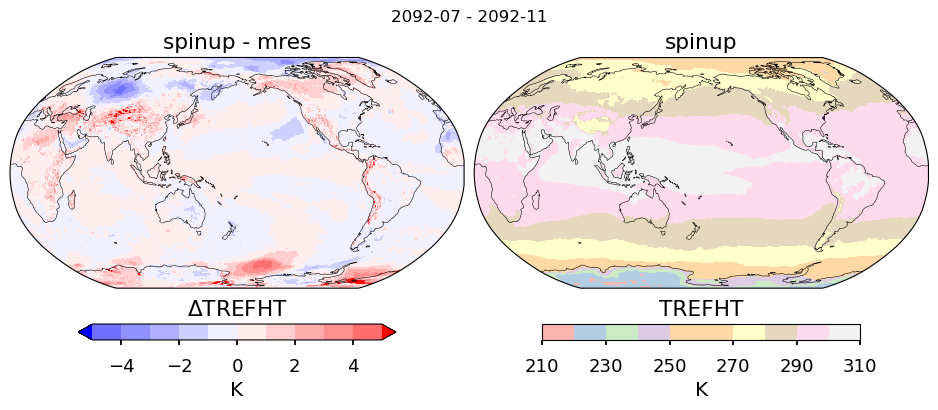

In [36]:
VAR = 'TREFHT'
tslice = slice('2092-07','2092-11')
dlevels = range(-5,6,1)
levels = range(210,311,10)
Y = (cam['hrt'][VAR].sel(time=tslice).interp(lat=cam['geo'].lat, lon=cam['geo'].lon) - cam['geo'][VAR].sel(time=tslice)).mean('time', keep_attrs=True)

fig,ax = plt.subplots(1,2, layout="compressed", figsize=(10,4), subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
pd = ax[0].contourf(Y.lon, Y.lat, Y, levels=dlevels, cmap='bwr', transform=ccrs.PlateCarree(), extend='both',
                    norm=CenteredNorm(vcenter=0, halfrange=8))
ax[0].coastlines()
cb = fig.colorbar(pd, ax=ax[0], orientation='horizontal', shrink=.7, label=cam['hrt'][VAR].units)
cb.ax.set_title(r"$\Delta$"+VAR)
ax[0].set_title('spinup - mres')

ps = ax[1].contourf(cam['hrt'].lon, cam['hrt'].lat, cam['hrt'][VAR].sel(time=tslice).mean('time',keep_attrs=True), 
                    levels=levels, transform=ccrs.PlateCarree(), cmap='Pastel1')
ax[1].set_title('spinup')
ax[1].coastlines()
cb2 = fig.colorbar(ps, ax=ax[1], orientation='horizontal', shrink=.7, label=cam['hrt'][VAR].units)
cb2.ax.set_title(VAR)
fig.suptitle(f"{tslice.start} - {tslice.stop}")

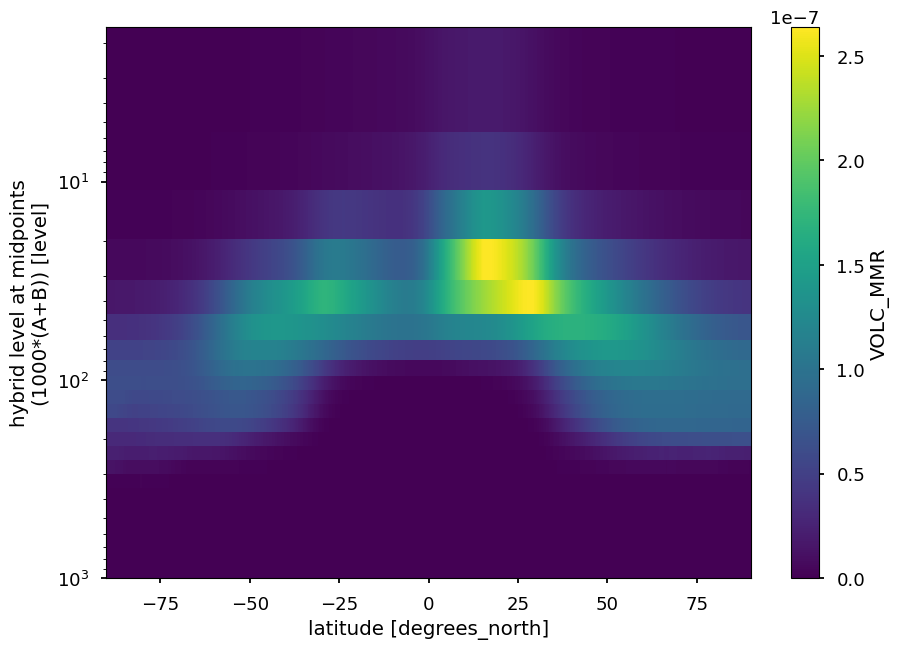

In [16]:
cam['hr1'].VOLC_MMR.mean(('time','lon')).plot()
plt.gca().invert_yaxis()
plt.gca().set_yscale('log')

In [40]:
%%time
VAR = 'T700'
Y = {
    'geo':(wmean(cam['geo'][VAR], cam['geo'].gw, ('lat','lon'), keep_attrs=True).
           groupby('time.year').mean(keep_attrs=True).compute()),
    'cnt':(wmean(cam['cnt'][VAR], cam['cnt'].gw, ('lat','lon'), keep_attrs=True).
           groupby('time.year').mean(keep_attrs=True).compute()),
}

CPU times: user 5.8 s, sys: 394 ms, total: 6.19 s
Wall time: 59.3 s


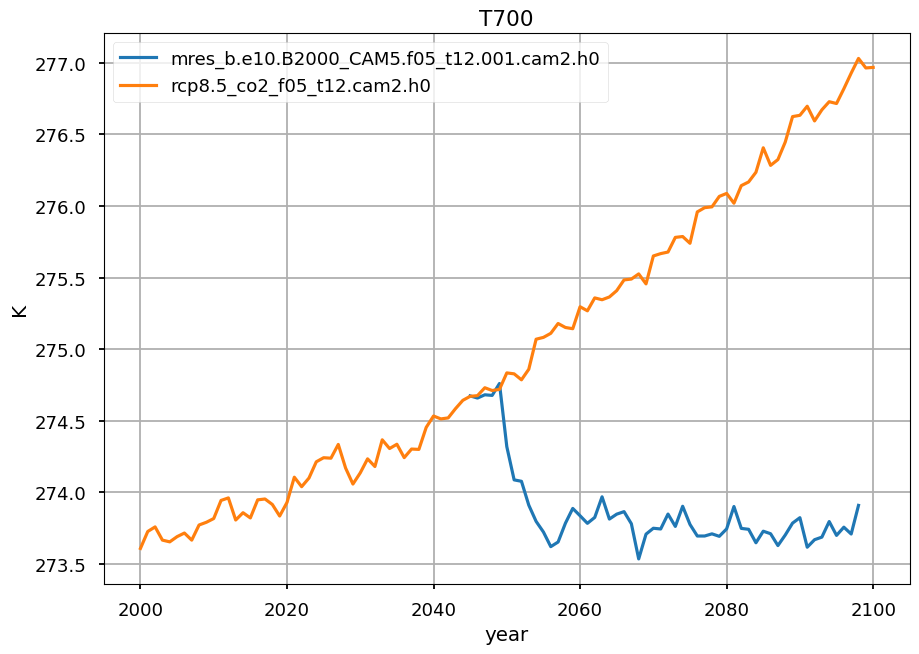

In [41]:
# Plot time series
plt.plot(Y['geo'].year, Y['geo'], label='.'.join(os.path.basename(camg).split('.')[:-2]))
plt.plot(Y['cnt'].year, Y['cnt'], label='.'.join(os.path.basename(camc).split('.')[:-2]))
plt.grid()
plt.title(VAR); plt.ylabel(Y['geo'].units); plt.xlabel('year')
plt.legend()

In [34]:
%%time
VAR = 'FLNT'
Y = {
    'geo':(wmean(cam['geo'][VAR], cam['geo'].gw, ('lat','lon'), keep_attrs=True).
           groupby('time.year').mean(keep_attrs=True).compute()),
    'cnt':(wmean(cam['cnt'][VAR], cam['cnt'].gw, ('lat','lon'), keep_attrs=True).
           groupby('time.year').mean(keep_attrs=True).compute()),
}

CPU times: user 8.44 s, sys: 720 ms, total: 9.16 s
Wall time: 1min 2s


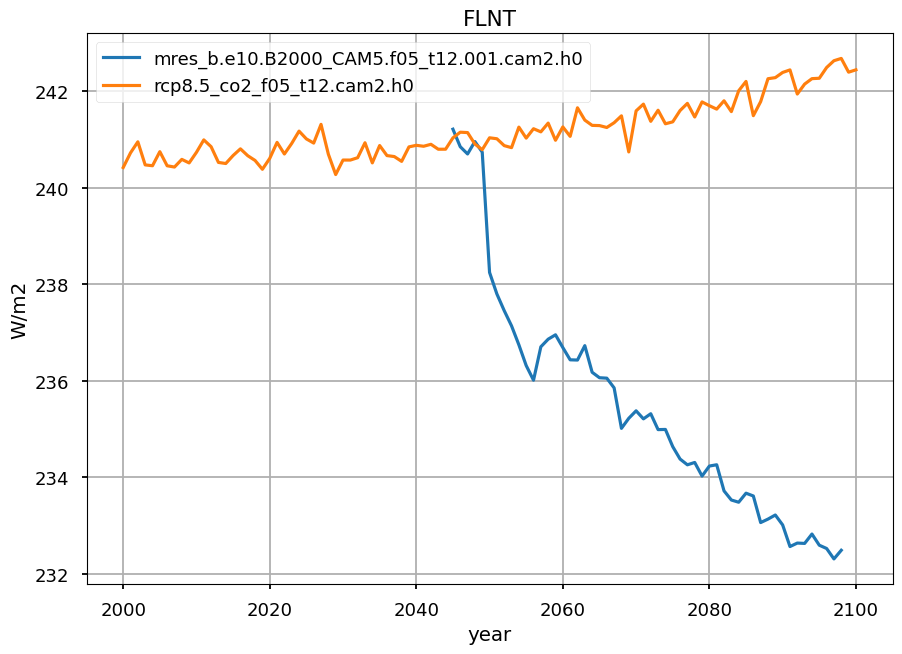

In [35]:
# Plot time series
plt.plot(Y['geo'].year, Y['geo'], label='.'.join(os.path.basename(camg).split('.')[:-2]))
plt.plot(Y['cnt'].year, Y['cnt'], label='.'.join(os.path.basename(camc).split('.')[:-2]))
plt.grid()
plt.title(VAR); plt.ylabel(Y['geo'].units); plt.xlabel('year')
plt.legend()

In [11]:
%%time
VAR = 'U'
Y = {
    'geo':(wmean(cam['geo'][VAR].isel(lev=-1), cam['geo'].gw, ('lat','lon'), keep_attrs=True).
           groupby('time.year').mean(keep_attrs=True).compute()),
    'cnt':(wmean(cam['cnt'][VAR].isel(lev=-1), cam['cnt'].gw, ('lat','lon'), keep_attrs=True).
           groupby('time.year').mean(keep_attrs=True).compute()),
}

CPU times: user 5.59 s, sys: 366 ms, total: 5.96 s
Wall time: 59.1 s


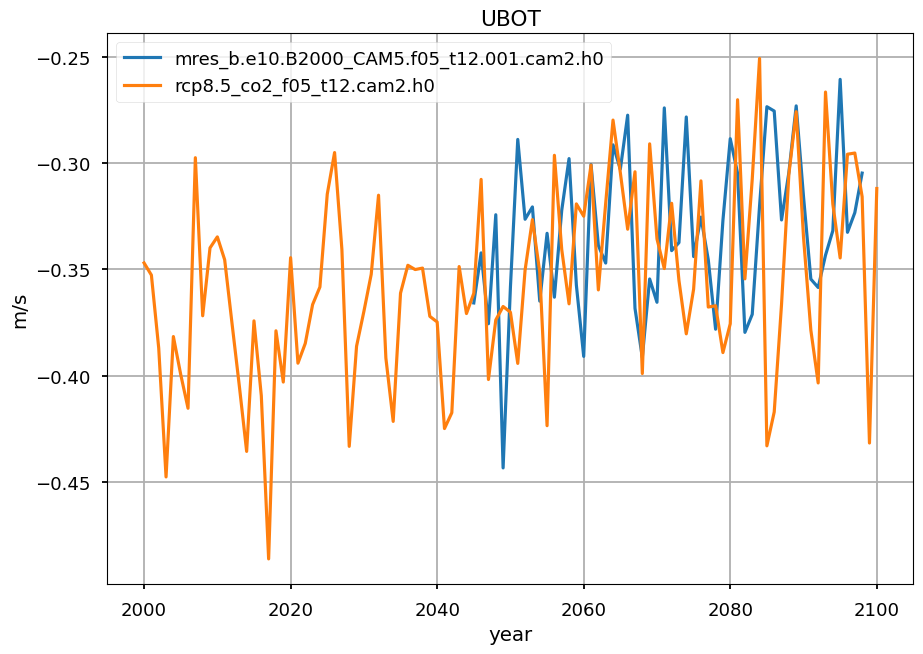

In [12]:
# Plot time series
plt.plot(Y['geo'].year, Y['geo'], label='.'.join(os.path.basename(camg).split('.')[:-2]))
plt.plot(Y['cnt'].year, Y['cnt'], label='.'.join(os.path.basename(camc).split('.')[:-2]))
plt.grid()
plt.title("UBOT"); plt.ylabel(Y['geo'].units); plt.xlabel('year')
plt.legend()

In [11]:
%%time
VAR = 'TREFHT'
tslice = slice('2045','2049')
Y = {
    'geo':(cam['geo'][VAR].sel(time=tslice).groupby('time.year').mean(keep_attrs=True).compute()),
    'cnt':(cam['cnt'][VAR].sel(time=tslice).groupby('time.year').mean(keep_attrs=True).compute()),
}
print('geo:',Y['geo'].year.min().data, Y['geo'].year.max().data)
print('cnt:',Y['cnt'].year.min().data, Y['cnt'].year.max().data)

sp = np.sqrt((Y['cnt'].std('year')**2+Y['geo'].std('year'))/2)
t = (Y['cnt'].mean('year') - Y['geo'].mean('year'))/(sp * np.sqrt(2/len(Y['geo'].year)))

geo: 2045 2049
cnt: 2045 2049
CPU times: user 315 ms, sys: 23.9 ms, total: 339 ms
Wall time: 1.98 s


Text(0.5, 0.28, 'geo - cnt\n(hatching: means are different p<0.05)')

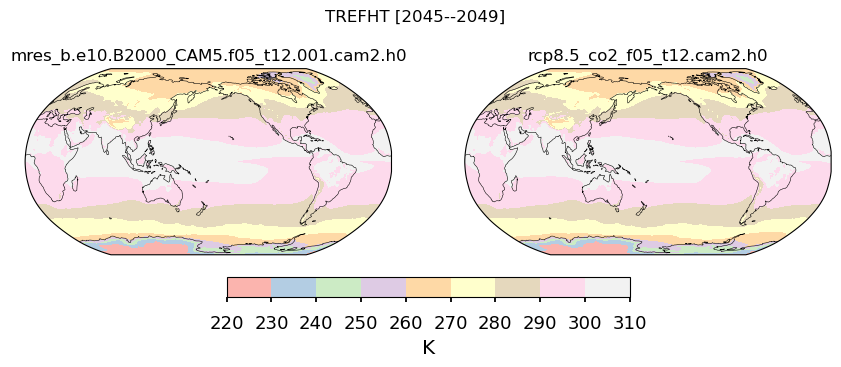

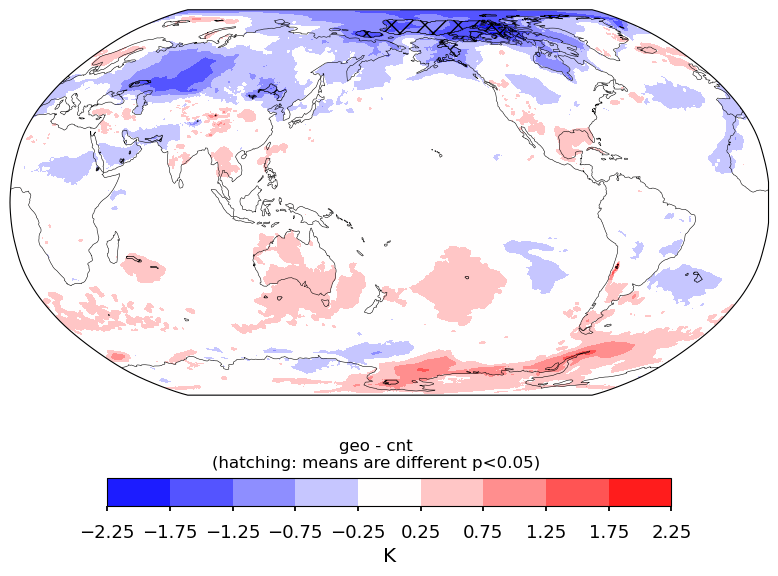

In [17]:
# Plot maps
levels = np.arange(220,311,10)
levels2 = np.linspace(-2.25,2.25,10)
cmap = 'Pastel1'
alpha = 2.776 # t value corresponding to p = 0.05

fig, ax = plt.subplots(1,2,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
p0 = ax[0].contourf(Y['geo'].lon, Y['geo'].lat, Y['geo'].mean('year'), levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[0].set_title('.'.join(os.path.basename(camg).split('.')[:-2]), fontsize=12)
ax[1].contourf(Y['cnt'].lon, Y['cnt'].lat, Y['cnt'].mean('year'), levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[1].set_title('.'.join(os.path.basename(camc).split('.')[:-2]), fontsize=12)
ax[0].coastlines()
ax[1].coastlines()
fig.colorbar(p0, ax=ax, orientation='horizontal', shrink=.5, pad=.04, label=Y['cnt'].units)
fig.suptitle(f"{VAR} [{tslice.start}--{tslice.stop}]",y=0.6)

fig2 = plt.figure()
ax2 = plt.axes(projection=ax[0].projection)
pd = ax2.contourf(Y['geo'].lon, Y['geo'].lat, (Y['geo']-Y['cnt']).mean('year'), levels=levels2, cmap='bwr', transform=ccrs.PlateCarree())
cs = ax2.contourf(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=1, colors='k', hatches=['','\\//'], alpha=0, transform=ccrs.PlateCarree())
ct = ax2.contour(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=[0.5], colors='k', linewidths=.5, transform=ccrs.PlateCarree())
ax2.coastlines()
fig2.colorbar(pd, ax=ax2, orientation='horizontal', shrink=.7, label=Y['geo'].units)
fig2.suptitle('geo - cnt\n(hatching: means are different p<0.05)', y=.28)

In [31]:
%%time
VAR = 'FSNT'
tslice = slice('2045','2049')
Y = {
    'geo':(cam['geo'][VAR].sel(time=tslice).groupby('time.year').mean(keep_attrs=True)).compute(),
    'cnt':(cam['cnt'][VAR].sel(time=tslice).groupby('time.year').mean(keep_attrs=True)).compute(),
}
print('geo:',Y['geo'].year.min().values, Y['geo'].year.max().data, Y['geo'].min().data, Y['geo'].max().data)
print('cnt:',Y['cnt'].year.min().values, Y['cnt'].year.max().data, Y['cnt'].min().data, Y['cnt'].max().data)

sp = np.sqrt((Y['cnt'].std('year')**2+Y['geo'].std('year'))/2).compute()
t = (Y['cnt'].mean('year') - Y['geo'].mean('year'))/(sp * np.sqrt(2/len(Y['geo'].year))).compute()

Y['geo'] = Y['geo'].mean('year', keep_attrs=True).compute()
Y['cnt'] = Y['cnt'].mean('year', keep_attrs=True).compute()

geo: 2045 2049 45.815277099609375 357.1092834472656
cnt: 2045 2049 45.68666458129883 358.0787048339844
CPU times: user 265 ms, sys: 33.9 ms, total: 299 ms
Wall time: 916 ms


CPU times: user 1min 27s, sys: 9.53 s, total: 1min 36s
Wall time: 1min 28s


Text(0.5, 0.28, 'geo - cnt\n(hatching: means are different p<0.05)')

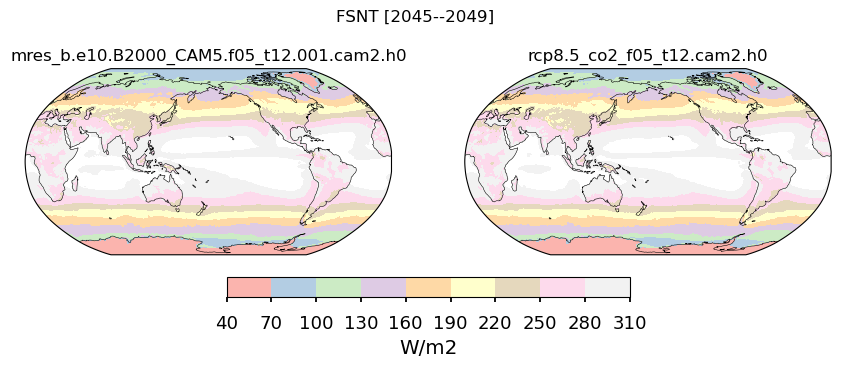

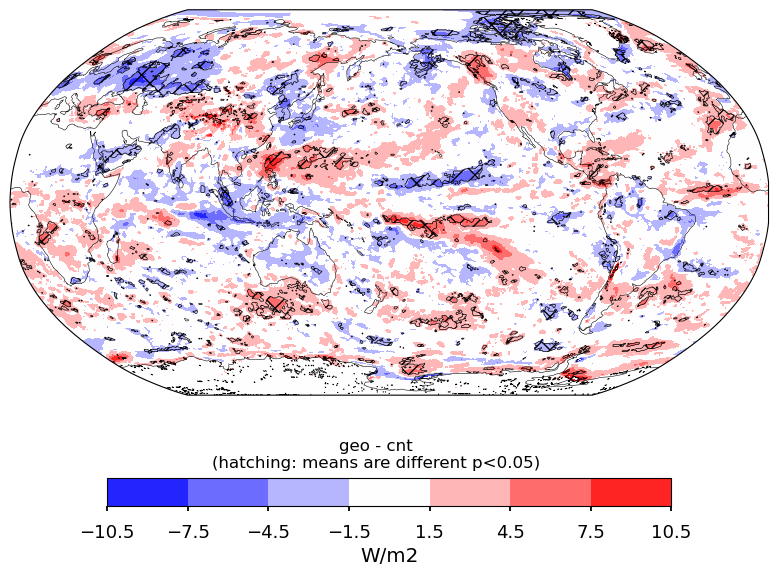

In [33]:
%%time
levels = np.arange(40,311,10)
levels2 = np.arange(-10.5,10.51,3)
cmap = 'Pastel1'
alpha = 2.776 # t value corresponding to p = 0.05

fig, ax = plt.subplots(1,2,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
p0 = ax[0].contourf(Y['geo'].lon, Y['geo'].lat, Y['geo'], levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[0].set_title('.'.join(os.path.basename(camg).split('.')[:-2]), fontsize=12)
ax[1].contourf(Y['cnt'].lon, Y['cnt'].lat, Y['cnt'], levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[1].set_title('.'.join(os.path.basename(camc).split('.')[:-2]), fontsize=12)
ax[0].coastlines()
ax[1].coastlines()
fig.colorbar(p0, ax=ax, orientation='horizontal', shrink=.5, pad=.04, label=Y['cnt'].units)
fig.suptitle(f"{VAR} [{tslice.start}--{tslice.stop}]",y=0.6)

fig2 = plt.figure()
ax2 = plt.axes(projection=ax[0].projection)
pd = ax2.contourf(Y['geo'].lon, Y['geo'].lat, (Y['geo']-Y['cnt']), levels=levels2, cmap='bwr', transform=ccrs.PlateCarree())
cs = ax2.contourf(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=1, colors='k', hatches=['','\\//'], alpha=0, transform=ccrs.PlateCarree())
ct = ax2.contour(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=[0.5], colors='k', linewidths=.5, transform=ccrs.PlateCarree())
ax2.coastlines()
fig2.colorbar(pd, ax=ax2, orientation='horizontal', shrink=.7, label=Y['geo'].units)
fig2.suptitle('geo - cnt\n(hatching: means are different p<0.05)', y=.28)

In [37]:
%%time
VAR = 'FLNT'
tslice = slice('2045','2049')
Y = {
    'geo':(cam['geo'][VAR].sel(time=tslice).groupby('time.year').mean(keep_attrs=True)).compute(),
    'cnt':(cam['cnt'][VAR].sel(time=tslice).groupby('time.year').mean(keep_attrs=True)).compute(),
}
print('geo:',Y['geo'].year.min().values, Y['geo'].year.max().data, Y['geo'].min().data, Y['geo'].max().data)
print('cnt:',Y['cnt'].year.min().values, Y['cnt'].year.max().data, Y['cnt'].min().data, Y['cnt'].max().data)

sp = np.sqrt((Y['cnt'].std('year')**2+Y['geo'].std('year'))/2).compute()
t = (Y['cnt'].mean('year') - Y['geo'].mean('year'))/(sp * np.sqrt(2/len(Y['geo'].year))).compute()

Y['geo'] = Y['geo'].mean('year', keep_attrs=True).compute()
Y['cnt'] = Y['cnt'].mean('year', keep_attrs=True).compute()

print('geo:',Y['geo'].min().data, Y['geo'].max().data)
print('cnt:',Y['cnt'].min().data, Y['cnt'].max().data)
print('dif:',(Y['geo']-Y['cnt']).min().data, (Y['geo']-Y['cnt']).max().data)

geo: 2045 2049 126.06214141845703 297.1809997558594
cnt: 2045 2049 126.2330322265625 300.9821472167969
geo: 127.29048919677734 294.67596435546875
cnt: 127.0342788696289 297.1031188964844
dif: -10.543930053710938 8.924224853515625
CPU times: user 333 ms, sys: 28.8 ms, total: 362 ms
Wall time: 2.64 s


CPU times: user 13.1 s, sys: 688 ms, total: 13.8 s
Wall time: 13.3 s


Text(0.5, 0.28, 'geo - cnt\n(hatching: means are different p<0.05)')

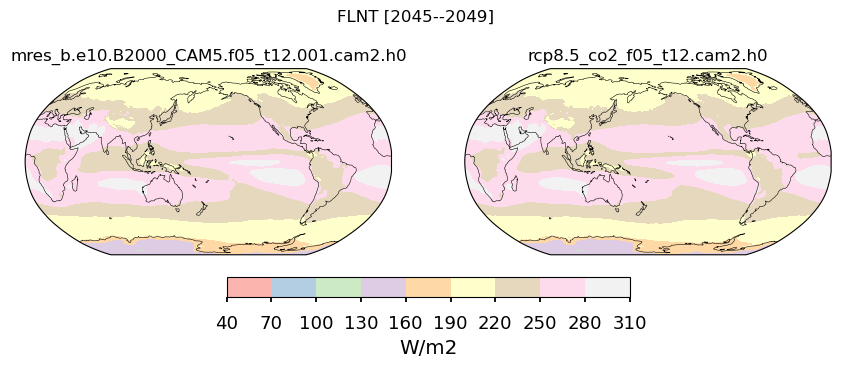

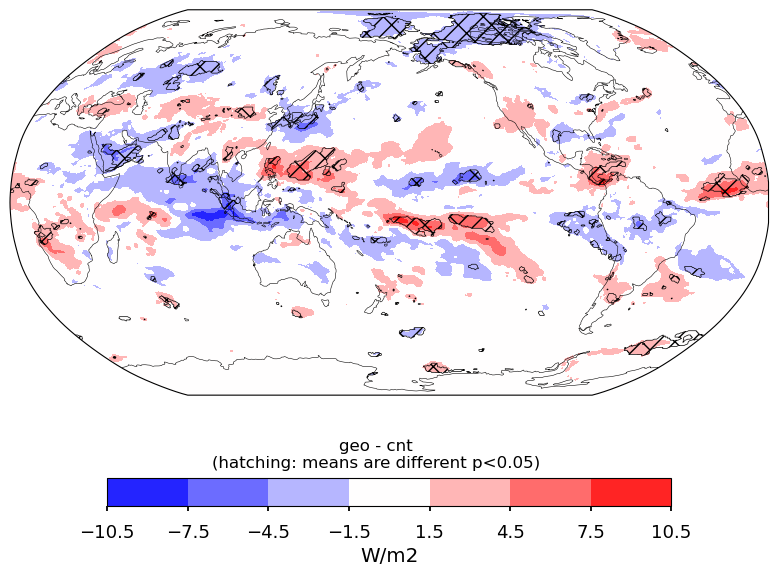

In [38]:
%%time
levels = np.arange(40,311,10)
levels2 = np.arange(-10.5,10.51,3)
cmap = 'Pastel1'
alpha = 2.776 # t value corresponding to p = 0.05

fig, ax = plt.subplots(1,2,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
p0 = ax[0].contourf(Y['geo'].lon, Y['geo'].lat, Y['geo'], levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[0].set_title('.'.join(os.path.basename(camg).split('.')[:-2]), fontsize=12)
ax[1].contourf(Y['cnt'].lon, Y['cnt'].lat, Y['cnt'], levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[1].set_title('.'.join(os.path.basename(camc).split('.')[:-2]), fontsize=12)
ax[0].coastlines()
ax[1].coastlines()
fig.colorbar(p0, ax=ax, orientation='horizontal', shrink=.5, pad=.04, label=Y['cnt'].units)
fig.suptitle(f"{VAR} [{tslice.start}--{tslice.stop}]",y=0.6)

fig2 = plt.figure()
ax2 = plt.axes(projection=ax[0].projection)
pd = ax2.contourf(Y['geo'].lon, Y['geo'].lat, (Y['geo']-Y['cnt']), levels=levels2, cmap='bwr', transform=ccrs.PlateCarree())
cs = ax2.contourf(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=1, colors='k', hatches=['','\\//'], alpha=0, transform=ccrs.PlateCarree())
ct = ax2.contour(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=[0.5], colors='k', linewidths=.5, transform=ccrs.PlateCarree())
ax2.coastlines()
fig2.colorbar(pd, ax=ax2, orientation='horizontal', shrink=.7, label=Y['geo'].units)
fig2.suptitle('geo - cnt\n(hatching: means are different p<0.05)', y=.28)

In [42]:
%%time
VAR = 'T700'
tslice = slice('2045','2049')
Y = {
    'geo':(cam['geo'][VAR].sel(time=tslice).groupby('time.year').mean(keep_attrs=True)).compute(),
    'cnt':(cam['cnt'][VAR].sel(time=tslice).groupby('time.year').mean(keep_attrs=True)).compute(),
}
print('geo:',Y['geo'].year.min().values, Y['geo'].year.max().data, Y['geo'].min().data, Y['geo'].max().data)
print('cnt:',Y['cnt'].year.min().values, Y['cnt'].year.max().data, Y['cnt'].min().data, Y['cnt'].max().data)

sp = np.sqrt((Y['cnt'].std('year')**2+Y['geo'].std('year'))/2).compute()
t = (Y['cnt'].mean('year') - Y['geo'].mean('year'))/(sp * np.sqrt(2/len(Y['geo'].year))).compute()

Y['geo'] = Y['geo'].mean('year', keep_attrs=True).compute()
Y['cnt'] = Y['cnt'].mean('year', keep_attrs=True).compute()

print('geo:',Y['geo'].min().data, Y['geo'].max().data)
print('cnt:',Y['cnt'].min().data, Y['cnt'].max().data)
print('dif:',(Y['geo']-Y['cnt']).min().data, (Y['geo']-Y['cnt']).max().data)

geo: 2045 2049 222.7403564453125 286.3219299316406
cnt: 2045 2049 221.27841186523438 286.2886657714844
geo: 223.7391357421875 286.1101989746094
cnt: 223.7789306640625 286.1544494628906
dif: -1.4141082763671875 0.813873291015625
CPU times: user 313 ms, sys: 28.2 ms, total: 342 ms
Wall time: 2.43 s


CPU times: user 6.47 s, sys: 404 ms, total: 6.87 s
Wall time: 6.59 s


Text(0.5, 0.28, 'geo - cnt\n(hatching: means are different p<0.05)')

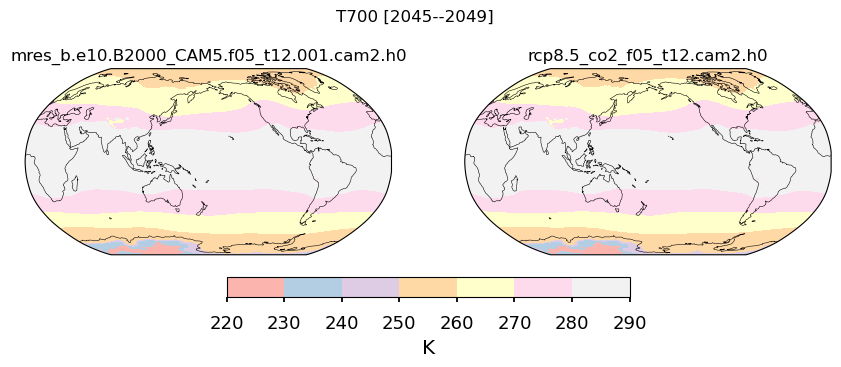

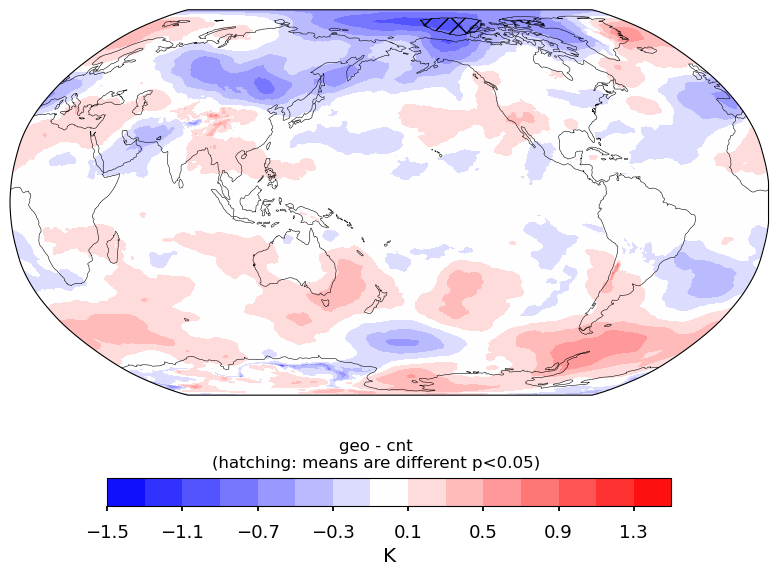

In [44]:
%%time
levels = np.arange(220,291,10)
levels2 = np.arange(-1.5,1.51,.2)
cmap = 'Pastel1'
alpha = 2.776 # t value corresponding to p = 0.05

fig, ax = plt.subplots(1,2,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
p0 = ax[0].contourf(Y['geo'].lon, Y['geo'].lat, Y['geo'], levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[0].set_title('.'.join(os.path.basename(camg).split('.')[:-2]), fontsize=12)
ax[1].contourf(Y['cnt'].lon, Y['cnt'].lat, Y['cnt'], levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[1].set_title('.'.join(os.path.basename(camc).split('.')[:-2]), fontsize=12)
ax[0].coastlines()
ax[1].coastlines()
fig.colorbar(p0, ax=ax, orientation='horizontal', shrink=.5, pad=.04, label=Y['cnt'].units)
fig.suptitle(f"{VAR} [{tslice.start}--{tslice.stop}]",y=0.6)

fig2 = plt.figure()
ax2 = plt.axes(projection=ax[0].projection)
pd = ax2.contourf(Y['geo'].lon, Y['geo'].lat, (Y['geo']-Y['cnt']), levels=levels2, cmap='bwr', transform=ccrs.PlateCarree())
cs = ax2.contourf(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=1, colors='k', hatches=['','\\//'], alpha=0, transform=ccrs.PlateCarree())
ct = ax2.contour(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=[0.5], colors='k', linewidths=.5, transform=ccrs.PlateCarree())
ax2.coastlines()
fig2.colorbar(pd, ax=ax2, orientation='horizontal', shrink=.7, label=Y['geo'].units)
fig2.suptitle('geo - cnt\n(hatching: means are different p<0.05)', y=.28)

In [7]:
%%time
VAR = 'U'
tslice = slice('2045','2049')
Y = {
    'geo':(cam['geo'][VAR].isel(lev=-1).sel(time=tslice).groupby('time.year').mean(keep_attrs=True)).compute(),
    'cnt':(cam['cnt'][VAR].isel(lev=-1).sel(time=tslice).groupby('time.year').mean(keep_attrs=True)).compute(),
}
print('geo:',Y['geo'].year.min().values, Y['geo'].year.max().data, Y['geo'].min().data, Y['geo'].max().data)
print('cnt:',Y['cnt'].year.min().values, Y['cnt'].year.max().data, Y['cnt'].min().data, Y['cnt'].max().data)

sp = np.sqrt((Y['cnt'].std('year')**2+Y['geo'].std('year'))/2).compute()
t = (Y['cnt'].mean('year') - Y['geo'].mean('year'))/(sp * np.sqrt(2/len(Y['geo'].year))).compute()

Y['geo'] = Y['geo'].mean('year', keep_attrs=True).compute()
Y['cnt'] = Y['cnt'].mean('year', keep_attrs=True).compute()

print('geo:',Y['geo'].min().data, Y['geo'].max().data)
print('cnt:',Y['cnt'].min().data, Y['cnt'].max().data)
print('dif:',(Y['geo']-Y['cnt']).min().data, (Y['geo']-Y['cnt']).max().data)

geo: 2045 2049 -13.150174140930176 16.37430763244629
cnt: 2045 2049 -12.934591293334961 16.550683975219727
geo: -12.822675704956055 15.807580947875977
cnt: -12.706661224365234 15.892970085144043
dif: -0.9646300673484802 1.2082653045654297
CPU times: user 452 ms, sys: 40.4 ms, total: 493 ms
Wall time: 7.09 s


CPU times: user 13.9 s, sys: 1.08 s, total: 15 s
Wall time: 14.3 s


Text(0.5, 0.28, 'geo - cnt\n(hatching: means are different p<0.05)')

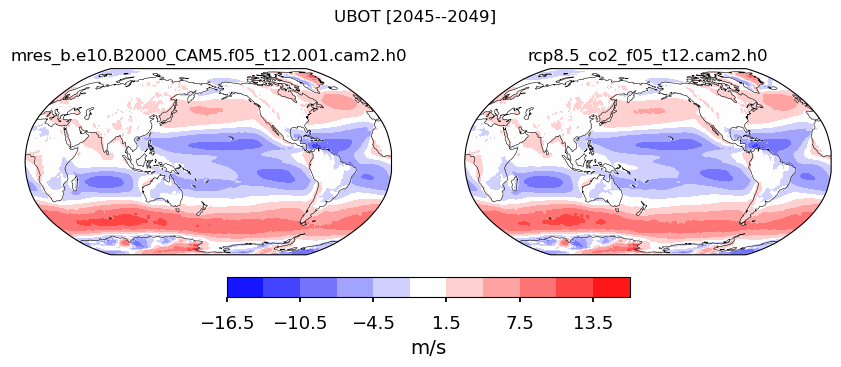

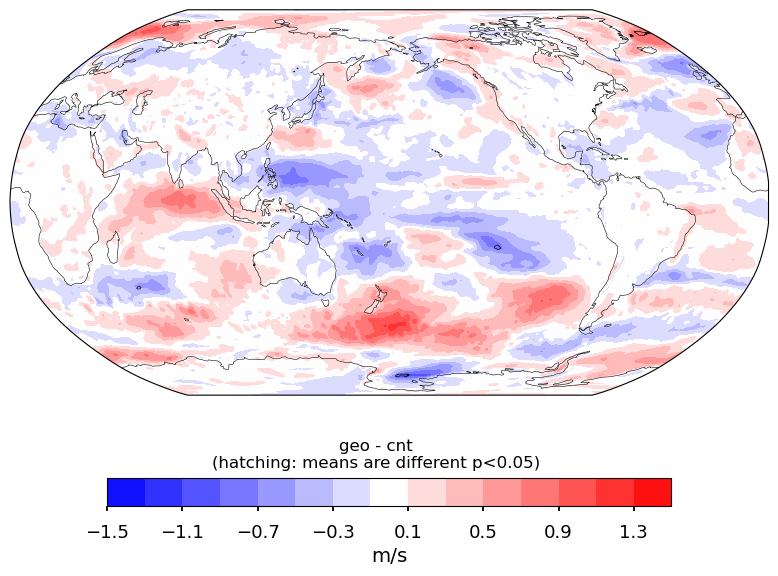

In [11]:
%%time
levels = np.arange(-16.5,16.51,3)
levels2 = np.arange(-1.5,1.51,.2)
cmap = 'bwr'
alpha = 2.776 # t value corresponding to p = 0.05

fig, ax = plt.subplots(1,2,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
p0 = ax[0].contourf(Y['geo'].lon, Y['geo'].lat, Y['geo'], levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[0].set_title('.'.join(os.path.basename(camg).split('.')[:-2]), fontsize=12)
ax[1].contourf(Y['cnt'].lon, Y['cnt'].lat, Y['cnt'], levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[1].set_title('.'.join(os.path.basename(camc).split('.')[:-2]), fontsize=12)
ax[0].coastlines()
ax[1].coastlines()
fig.colorbar(p0, ax=ax, orientation='horizontal', shrink=.5, pad=.04, label=Y['cnt'].units)
fig.suptitle(f"UBOT [{tslice.start}--{tslice.stop}]",y=0.6)

fig2 = plt.figure()
ax2 = plt.axes(projection=ax[0].projection)
pd = ax2.contourf(Y['geo'].lon, Y['geo'].lat, (Y['geo']-Y['cnt']), levels=levels2, cmap='bwr', transform=ccrs.PlateCarree())
cs = ax2.contourf(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=1, colors='k', hatches=['','\\//'], alpha=0, transform=ccrs.PlateCarree())
ct = ax2.contour(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=[0.5], colors='k', linewidths=.5, transform=ccrs.PlateCarree())
ax2.coastlines()
fig2.colorbar(pd, ax=ax2, orientation='horizontal', shrink=.7, label=Y['geo'].units)
fig2.suptitle('geo - cnt\n(hatching: means are different p<0.05)', y=.28)

In [20]:
%%time
VAR = 'U'
tslice = slice('2045','2049')
Y = {
    'geo':(cam['geo'][VAR].mean('lon', keep_attrs=True).sel(time=tslice).groupby('time.year').mean(keep_attrs=True)).compute(),
    'cnt':(cam['cnt'][VAR].mean('lon', keep_attrs=True).sel(time=tslice).groupby('time.year').mean(keep_attrs=True)).compute(),
}
print('geo:',Y['geo'].year.min().values, Y['geo'].year.max().data, Y['geo'].min().data, Y['geo'].max().data)
print('cnt:',Y['cnt'].year.min().values, Y['cnt'].year.max().data, Y['cnt'].min().data, Y['cnt'].max().data)

sp = np.sqrt((Y['cnt'].std('year')**2+Y['geo'].std('year'))/2).compute()
t = (Y['cnt'].mean('year') - Y['geo'].mean('year'))/(sp * np.sqrt(2/len(Y['geo'].year))).compute()

Y['geo'] = Y['geo'].mean('year', keep_attrs=True).compute()
Y['cnt'] = Y['cnt'].mean('year', keep_attrs=True).compute()

print('geo:',Y['geo'].min().data, Y['geo'].max().data)
print('cnt:',Y['cnt'].min().data, Y['cnt'].max().data)
print('dif:',(Y['geo']-Y['cnt']).min().data, (Y['geo']-Y['cnt']).max().data)

geo: 2045 2049 -20.20597267150879 51.48232650756836
cnt: 2045 2049 -19.403488159179688 52.57223892211914
geo: -18.669437408447266 50.1750373840332
cnt: -18.64817237854004 51.06236267089844
dif: -1.1798362731933594 0.9276547431945801
CPU times: user 415 ms, sys: 37.7 ms, total: 453 ms
Wall time: 4.22 s


CPU times: user 77.9 ms, sys: 3.05 ms, total: 80.9 ms
Wall time: 78.8 ms


Text(0.5, 0.3, 'geo - cnt\n(hatching: means are different p<0.05)')

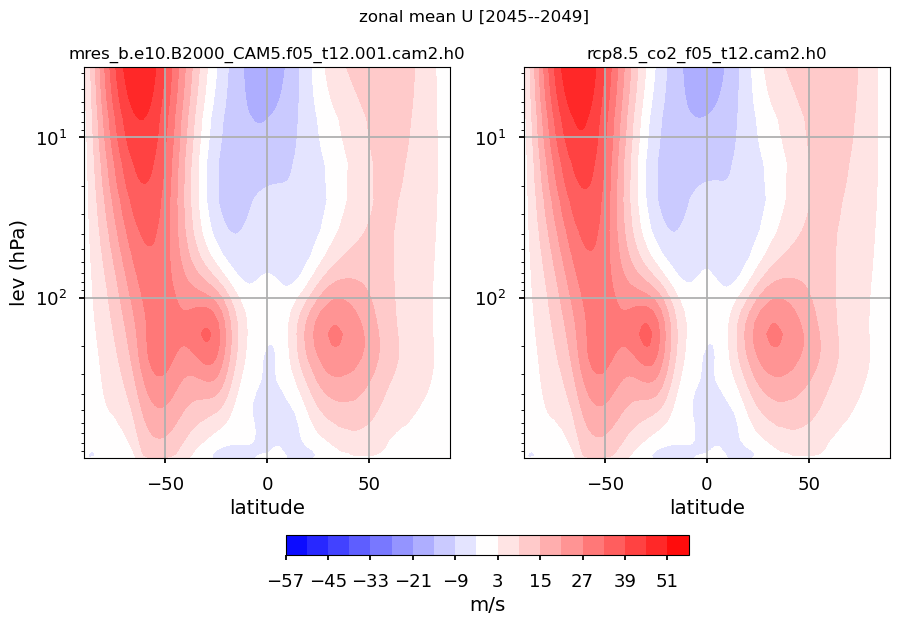

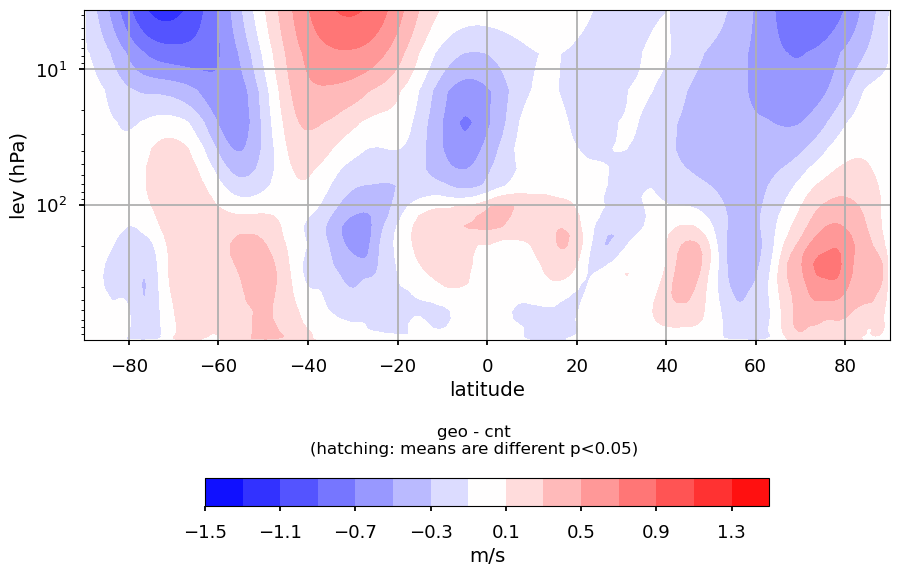

In [69]:
%%time
levels = np.arange(-57,57.1,6)
levels2 = np.arange(-1.5,1.51,.2)
cmap = 'bwr'
alpha = 2.776 # t value corresponding to p = 0.05

fig, ax = plt.subplots(1,2)
p0 = ax[0].contourf(Y['geo'].lat, Y['geo'].lev, Y['geo'], levels=levels, cmap=cmap)
ax[0].set_title('.'.join(os.path.basename(camg).split('.')[:-2]), fontsize=12)
ax[0].invert_yaxis()
ax[0].set_yscale('log')
ax[0].grid()
ax[0].set_xlabel('latitude')
ax[0].set_ylabel('lev (hPa)')
ax[1].contourf(Y['cnt'].lat, Y['cnt'].lev, Y['cnt'], levels=levels, cmap=cmap)
ax[1].set_title('.'.join(os.path.basename(camc).split('.')[:-2]), fontsize=12)
ax[1].invert_yaxis()
ax[1].set_yscale('log')
ax[1].grid()
ax[1].set_xlabel('latitude')
fig.colorbar(p0, ax=ax, orientation='horizontal', shrink=.5, pad=.14, label=Y['cnt'].units)
fig.suptitle(f"zonal mean U [{tslice.start}--{tslice.stop}]",y=.96)

fig2 = plt.figure()
ax2 = plt.axes()
pd = ax2.contourf(Y['geo'].lat, Y['geo'].lev, (Y['geo']-Y['cnt']), levels=levels2, cmap='bwr')
cs = ax2.contourf(t.lat, t.lev, (abs(t)>alpha).clip(min=0,max=1), levels=1, colors='k', hatches=['','\\//'], alpha=0)
ct = ax2.contour(t.lat, t.lev, (abs(t)>alpha).clip(min=0,max=1), levels=[0.5], colors='k', linewidths=.5)
#ax2.coastlines()
ax2.invert_yaxis()
ax2.set_yscale('log')
ax2.grid()
ax2.set_ylabel('lev (hPa)')
ax2.set_xlabel('latitude')
fig2.colorbar(pd, ax=ax2, orientation='horizontal', shrink=.7, pad=.25, label=Y['geo'].units)
fig2.suptitle('geo - cnt\n(hatching: means are different p<0.05)', y=.30)